In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator


5.7.1


In [2]:
#linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
#linkRates

In [3]:
linkRates = pd.read_csv('input_file_version10.csv',index_col=[0])
linkRates

linkRates.rename(columns = {'eventSize':'EvSize', 'doublelpGBT':'doubleDAQlpGBT',"lpgbt_id":"DAQlpGBT"}, inplace = True)
linkRates


,layer,MB,type,lpGBTs,EvSize,DAQlpGBT,doubleDAQlpGBT
0,1,0,0,"[0, 1]",323.5744,0,True
1,1,1,0,[2],217.0022,2,False
2,1,2,0,"[3, 4]",364.5350,3,True
3,1,3,0,"[5, 6]",300.3104,5,True
4,1,4,1,[7],111.7748,7,False
...,...,...,...,...,...,...,...
1147,47,0,11,[2163],15.9518,2163,False
1148,47,0,11,[2164],16.1394,2164,False
1149,47,0,11,[2165],16.0978,2165,False
1150,47,0,11,[2166],16.0136,2166,False


In [4]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")
sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
pd.set_option('display.max_rows', 10)
SizeSortedRates


There is a total of 1240 lpGBT links:
 - 1064 singles, and
 - 88 doubles (with one ECOND straddling the pair)



,layer,MB,type,lpGBTs,EvSize,DAQlpGBT,doubleDAQlpGBT
1017,36,0,4,[2033],9.3722,2033,False
1011,36,0,4,[2027],9.3722,2027,False
1013,36,0,4,[2029],9.4092,2029,False
1008,36,0,4,[2024],9.4132,2024,False
1010,36,0,4,[2026],9.4256,2026,False
...,...,...,...,...,...,...,...
87,4,102,0,"[109, 110]",417.7118,109,True
48,3,2,0,"[61, 62]",447.8950,61,True
62,3,102,0,"[78, 79]",448.2116,78,True
98,5,2,0,"[123, 124]",449.7524,123,True


In [5]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")




There is a total of 1240 lpGBT links:
 - 1064 singles, and
 - 88 doubles (with one ECOND straddling the pair)



In [6]:
sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates

,layer,MB,type,lpGBTs,EvSize,DAQlpGBT,doubleDAQlpGBT
1017,36,0,4,[2033],9.3722,2033,False
1011,36,0,4,[2027],9.3722,2027,False
1013,36,0,4,[2029],9.4092,2029,False
1008,36,0,4,[2024],9.4132,2024,False
1010,36,0,4,[2026],9.4256,2026,False
...,...,...,...,...,...,...,...
87,4,102,0,"[109, 110]",417.7118,109,True
48,3,2,0,"[61, 62]",447.8950,61,True
62,3,102,0,"[78, 79]",448.2116,78,True
98,5,2,0,"[123, 124]",449.7524,123,True


In [7]:
assert( len(sortedRates)%2 == 0 )

In [8]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)

In [9]:
nFPGA = 16 #max=28
#runNumber = 3 #max=4
splitNumber=8

warmStart=False
hardStart=True

#---------------------------------------------------

nGBTSingles = int((n_singles*nFPGA)/nFPGA)
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = int((n_doubles*nFPGA)/nFPGA)
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
#maxSlinkRate = 300
nSlinks = nFPGA*12  #336

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles
maxGBTsPerSlink = 12
SlinkPerFPGA = 12


In [10]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")



Toy problem parameters:
- 1152 lpGBT inputs.
  - 1064 lpGBT singles, and
  - 88 lpGBT doubles.
- 192 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.


 - 16 FPGAs and
 - 12 Slinks served by each FPGA.



In [11]:
''''f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    [i for i in lowS.values()],
    kde=False,
    rug=True,
    label='Single lpGBT'
    )
plt.annotate('Average', xy=(avSlinkEvSize,0), xytext=(avSlinkEvSize, 30),  ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05, headwidth=4, width=1))
sns.distplot(
    [i for i in lowD.values()],
    kde=False,
    rug=True,
    label='Double lpGBT'
    )
plt.legend()
plt.xlabel("Event-Size")
plt.ylabel("lpGBT Numbers")
plt.savefig("lpGBT sunum.png",facecolor ="w")

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-11-6c4e67c212c3>, line 19)

In [12]:
def split_dict_equally(input_dict, chunks=2):
    "Splits dict by keys. Returns a list of dictionaries."
    # prep with empty dicts
    return_list = [dict() for idx in range(chunks)]
    idx = 0
    for k,v in input_dict.items():
        return_list[idx][k] = v
        if idx < chunks-1:  # indexes start at 0
            idx += 1
        else:
            idx = 0
    return return_list


In [13]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
if nFPGA==nFPGA:
    medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][int(nGBTSingles/3):-1*int(nGBTSingles/3)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTSingles/3):].to_dict()

lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
if nFPGA==nFPGA:
    medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

#------------------------------------------------------------

lowS_1={}
medS_1={}
highS_1=highS

lowD_1=lowD
medD_1=medD
highD_1=highD

    
#------------------------------------------------------------

if mode=='LtoH':
    medS_1.update(highS_1)
    lowS_1.update(medS_1)
    
    medD_1.update(highD_1)
    lowD_1.update(medD_1)
    
    singleGBTRates_1 = lowS_1
    doubleGBTRates_1 = lowD_1
if mode=='HtoL':
    medS_1.update(lowS_1)
    highS_1.update(medS_1)
    
    medD_1.update(lowD_1)
    highD_1.update(medD_1)
    
    singleGBTRates_1 = highS_1
    doubleGBTRates_1 = highD_1
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict())[1]
    doubleGBTRates_1 = split_dict_equally(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict())[1]

print(len(singleGBTRates_1))
print(singleGBTRates_1)
print(len(doubleGBTRates_1))
#print(doubleGBTRates_1)



354
{460: 88.5614, 943: 88.5662, 447: 88.58500000000001, 937: 88.67080000000001, 926: 88.698, 226: 88.7096, 241: 88.7214, 89: 88.8086, 921: 88.8456, 72: 88.8806, 210: 89.15520000000001, 195: 89.188, 966: 89.33240000000002, 950: 89.73020000000001, 473: 89.8988, 486: 89.9304, 944: 89.9632, 395: 90.1006, 408: 90.1304, 238: 90.4092, 219: 90.4728, 223: 90.5444, 234: 90.5652, 849: 91.3444, 437: 91.3738, 848: 91.3968, 331: 91.4984, 424: 91.5706, 316: 91.66, 411: 91.922, 398: 91.97299999999998, 86: 92.0644, 942: 92.0694, 367: 92.1102, 928: 92.1756, 934: 92.2102, 69: 92.2276, 381: 92.3036, 383: 92.4048, 369: 92.4804, 918: 93.0216, 920: 93.1098, 927: 93.14600000000002, 913: 93.1488, 295: 93.9966, 280: 94.1004, 282: 94.1144, 297: 94.1314, 434: 94.37, 421: 94.5508, 28: 95.2006, 13: 95.541, 933: 96.0372, 354: 96.5558, 340: 96.5796, 905: 96.7386, 911: 96.827, 268: 97.3472, 249: 97.3692, 385: 97.5016, 264: 97.5434, 371: 97.641, 253: 97.7502, 181: 97.9378, 166: 98.0102, 823: 98.0138, 822: 98.0664, 919

In [14]:
totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in doubleGBTRates_1.values()]) )

In [15]:
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /len(doubleGBTRates_1)+len(doubleGBTRates_1)}
Average Slink rate: {totalRate / nSlinks}
""")


Total lpGBT rate: 78733.7696
Average lpGBT rate: 982.7019272727273
Average Slink rate: 410.07171666666665



In [16]:
model = pyo.ConcreteModel()

In [17]:
Single1=[str(k) for k in singleGBTRates_1.keys()]
Double1 = [str(k) for k in doubleGBTRates_1.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
print(len(Single1))
#print(Double1)
#print(Slink)
#print(FPGA)

354


In [18]:
model.GKSingles1 = pyo.Var(Single1, Slink, initialize = 0, within = pyo.Binary)
model.GKDoubles1 = pyo.Var(Double1, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)


In [19]:
GKavSlinkRate = (totalRate/nSlinks)
#print(GKavSlinkRate)
model.GKSingles1.fix()
model.GKDoubles1.fix()

In [20]:
''''#Enter the file path
path = './ScriptRuns/lows16FPGA_run2_part_thershold15001.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-20-dd7f40eca173>, line 5)

In [21]:
#Enter the file path
path = './16_version10_swap_S.pkl'

with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [22]:
print("Average Slink Rate:", GKavSlinkRate)
print("Objective: ", value(model.objective))
model.objective.display()


Average Slink Rate: 410.07171666666665
Objective:  0.405445353403206
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.405445353403206


In [23]:
Single2_dict={}
for partNumber in range(9):
    singleGBTRates_2 = split_dict_equally(medS,8)[partNumber-1]

        #print('len(singleGBTRates_2): ',len(singleGBTRates_2))
        #print(singleGBTRates_2)


    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber]=Single2
for partNumber in [1,2]:
    
    singleGBTRates_2 = split_dict_equally(lowS,2)[partNumber-1]
        
    Single2=[str(k) for k in singleGBTRates_2.keys()]
    Single2_dict[partNumber+8]=Single2
Single2_dict

{0: ['975',
  '752',
  '890',
  '529',
  '668',
  '753',
  '1014',
  '777',
  '490',
  '786',
  '845',
  '536',
  '344',
  '660',
  '755',
  '887',
  '386',
  '449',
  '588',
  '825',
  '695',
  '555',
  '659',
  '651',
  '671',
  '798',
  '225',
  '623',
  '686',
  '573',
  '356',
  '498',
  '366',
  '649',
  '553',
  '474',
  '409',
  '574',
  '165',
  '877',
  '422',
  '951',
  '528',
  '463'],
 1: ['766',
  '981',
  '803',
  '968',
  '542',
  '1019',
  '833',
  '878',
  '477',
  '997',
  '987',
  '698',
  '523',
  '438',
  '497',
  '754',
  '837',
  '488',
  '724',
  '862',
  '824',
  '517',
  '599',
  '645',
  '432',
  '682',
  '452',
  '549',
  '633',
  '673',
  '539',
  '342',
  '513',
  '370',
  '637',
  '345',
  '448',
  '747',
  '90',
  '515',
  '341',
  '435',
  '717',
  '328',
  '959'],
 2: ['899',
  '790',
  '883',
  '819',
  '1046',
  '600',
  '838',
  '854',
  '776',
  '564',
  '787',
  '694',
  '685',
  '851',
  '501',
  '761',
  '960',
  '462',
  '458',
  '576',
  '697

In [24]:
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [25]:
L1=[]
L2=[]
for k, v in Vars.items():
    L1.append(v[0])
    L2.append(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)

/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


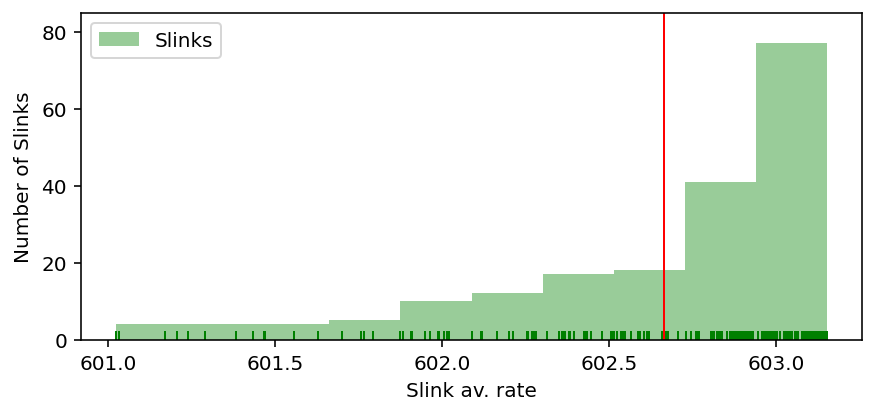

In [26]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
        #ilist -- o vars object için yani run için  GKsingles 2_3  mesela ayrılmış lpgbt rate id ler
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
plt.savefig('16 spga slink after final swap.png')

In [27]:
singleGBTRates_2_ALL={}
singleGBTRates_2_ALL.update(lowS)
singleGBTRates_2_ALL.update(medS)
#singleGBTRates_2_ALL.update()
singleGBTRates_2_ALL
Single2_ALL = [str(k) for k in singleGBTRates_2_ALL.keys()]

totalRate = ( sum([i for i in singleGBTRates_1.values()])+sum([i for i in singleGBTRates_2_ALL.values()])+sum([i for i in doubleGBTRates_1.values()]) )
GKavSlinkRate = (totalRate/nSlinks)
singleGBTRates_2_ALL

{2033: 9.3722,
 2027: 9.3722,
 2029: 9.4092,
 2024: 9.4132,
 2026: 9.4256,
 2035: 9.4454,
 2032: 9.47,
 2028: 9.49,
 2030: 9.493,
 2031: 9.5076,
 2025: 9.5316,
 2034: 9.5364,
 2012: 9.973,
 2015: 10.0134,
 2018: 10.0256,
 2014: 10.0448,
 2017: 10.0498,
 2023: 10.0502,
 2021: 10.0552,
 2020: 10.0722,
 2013: 10.2356,
 2016: 10.2656,
 2019: 10.2692,
 2022: 10.2712,
 2006: 10.7656,
 2003: 10.7886,
 2011: 10.7982,
 2000: 10.801,
 2009: 10.8076,
 2005: 10.8158,
 2002: 10.8342,
 2008: 10.8442,
 2047: 11.0104,
 2039: 11.0158,
 2010: 11.0288,
 2036: 11.0288,
 2045: 11.0294,
 2038: 11.0386,
 2004: 11.0388,
 2041: 11.051,
 2044: 11.082,
 2042: 11.0932,
 2007: 11.1082,
 2001: 11.1248,
 2043: 11.129,
 2040: 11.1378,
 2037: 11.1826,
 2046: 11.1882,
 2065: 13.978,
 2062: 14.0254,
 2068: 14.034,
 2069: 14.0374,
 2071: 14.0522,
 2113: 14.0566,
 2060: 14.057,
 2063: 14.0588,
 2066: 14.062,
 2114: 14.0672,
 2108: 14.0836,
 2115: 14.0886,
 2112: 14.0976,
 2109: 14.1076,
 2119: 14.1078,
 2118: 14.1264,
 20

In [28]:
Single_All=[str(k) for k in singleGBTRates_1.keys()]


In [29]:
for i in singleGBTRates_2_ALL:
    Single_All.append(i)
print(len(Single_All))
print(len(Single1))

1064
354


In [30]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

swapData()
ss = [i for i in {k: v for k, v in sorted(swapData().items(), key=lambda item: item[1],reverse=True)}.items()]
print(ss)

[('152', [603.15, [[117, 108.3082], [415, 151.8626], [820, 168.82719999999998], [462, 69.62440000000001], [1024, 53.229200000000006], [731, 51.2984]]]), ('48', [603.1498, [[250, 112.5288], [374, 263.70640000000003], [648, 67.03399999999999], [760, 67.12100000000001], [711, 76.2144], [2124, 16.5452]]]), ('151', [603.1486, [[354, 96.5558], [557, 135.6708], [457, 197.177], [353, 85.26400000000001], [1009, 35.7048], [941, 52.7762]]]), ('25', [603.1442, [[141, 365.4034], [707, 71.5156], [728, 70.4708], [2061, 14.151], [2107, 15.0104], [2157, 15.974], [764, 36.41179999999999], [2064, 14.2072]]]), ('13', [603.1410000000001, [[143, 118.5256], [494, 242.5558], [803, 59.8458], [710, 65.29639999999999], [386, 69.4036], [1013, 47.5138]]]), ('179', [603.1408, [[918, 93.0216], [209, 127.0844], [606, 222.2514], [497, 66.979], [785, 71.70660000000001], [2044, 11.082], [2039, 11.0158]]]), ('42', [603.1375999999999, [[197, 373.1586], [572, 65.075], [908, 51.4232], [737, 58.00600000000001], [973, 55.4748

In [31]:
L1

[['460',
  '943',
  '447',
  '937',
  '926',
  '226',
  '241',
  '89',
  '921',
  '72',
  '210',
  '195',
  '966',
  '950',
  '473',
  '486',
  '944',
  '395',
  '408',
  '238',
  '219',
  '223',
  '234',
  '849',
  '437',
  '848',
  '331',
  '424',
  '316',
  '411',
  '398',
  '86',
  '942',
  '367',
  '928',
  '934',
  '69',
  '381',
  '383',
  '369',
  '918',
  '920',
  '927',
  '913',
  '295',
  '280',
  '282',
  '297',
  '434',
  '421',
  '28',
  '13',
  '933',
  '354',
  '340',
  '905',
  '911',
  '268',
  '249',
  '385',
  '264',
  '371',
  '253',
  '181',
  '166',
  '823',
  '822',
  '919',
  '912',
  '357',
  '343',
  '382',
  '368',
  '148',
  '132',
  '910',
  '163',
  '312',
  '178',
  '325',
  '159',
  '327',
  '174',
  '310',
  '271',
  '256',
  '133',
  '149',
  '797',
  '87',
  '796',
  '70',
  '222',
  '237',
  '220',
  '235',
  '296',
  '281',
  '329',
  '189',
  '314',
  '204',
  '880',
  '299',
  '881',
  '284',
  '117',
  '99',
  '311',
  '326',
  '103',
  '113',
 

In [32]:
L3

{2033: 9.3722,
 2027: 9.3722,
 2029: 9.4092,
 2024: 9.4132,
 2026: 9.4256,
 2035: 9.4454,
 2032: 9.47,
 2028: 9.49,
 2030: 9.493,
 2031: 9.5076,
 2025: 9.5316,
 2034: 9.5364,
 2012: 9.973,
 2015: 10.0134,
 2018: 10.0256,
 2014: 10.0448,
 2017: 10.0498,
 2023: 10.0502,
 2021: 10.0552,
 2020: 10.0722,
 2013: 10.2356,
 2016: 10.2656,
 2019: 10.2692,
 2022: 10.2712,
 2006: 10.7656,
 2003: 10.7886,
 2011: 10.7982,
 2000: 10.801,
 2009: 10.8076,
 2005: 10.8158,
 2002: 10.8342,
 2008: 10.8442,
 2047: 11.0104,
 2039: 11.0158,
 2010: 11.0288,
 2036: 11.0288,
 2045: 11.0294,
 2038: 11.0386,
 2004: 11.0388,
 2041: 11.051,
 2044: 11.082,
 2042: 11.0932,
 2007: 11.1082,
 2001: 11.1248,
 2043: 11.129,
 2040: 11.1378,
 2037: 11.1826,
 2046: 11.1882,
 2065: 13.978,
 2062: 14.0254,
 2068: 14.034,
 2069: 14.0374,
 2071: 14.0522,
 2113: 14.0566,
 2060: 14.057,
 2063: 14.0588,
 2066: 14.062,
 2114: 14.0672,
 2108: 14.0836,
 2115: 14.0886,
 2112: 14.0976,
 2109: 14.1076,
 2119: 14.1078,
 2118: 14.1264,
 20

In [33]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])

In [34]:
slink_lpgbt_dict_rate={}

In [35]:
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKSingles'+dictNo
    
    for j in Slink:
        liste=[]
        for k in Single1:
            
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:
                liste.append(k)
        slink_lpgbt_dict_rate[j]=liste
        
        
        
                       
        
        
                

1


In [36]:
slink_lpgbt_dict_rate

{'1': ['266', '466'],
 '2': ['826', '337'],
 '3': ['130', '351'],
 '4': ['251', '558'],
 '5': ['207', '570'],
 '6': ['82', '546'],
 '7': ['190', '582'],
 '8': ['205', '108'],
 '9': ['721', '94'],
 '10': [],
 '11': ['192', '401'],
 '12': ['7', '427'],
 '13': ['143'],
 '14': ['127'],
 '15': ['269'],
 '16': [],
 '17': ['716', '388'],
 '18': ['160'],
 '19': ['177', '414'],
 '20': [],
 '21': [],
 '22': [],
 '23': ['254', '122'],
 '24': ['162', '138'],
 '25': [],
 '26': [],
 '27': [],
 '28': [],
 '29': [],
 '30': [],
 '31': ['744'],
 '32': ['745'],
 '33': ['29', '60'],
 '34': ['14', '77'],
 '35': [],
 '36': ['265'],
 '37': ['267'],
 '38': ['852'],
 '39': ['271'],
 '40': ['11'],
 '41': ['369'],
 '42': [],
 '43': [],
 '44': [],
 '45': ['252'],
 '46': [],
 '47': ['221'],
 '48': ['250'],
 '49': ['236'],
 '50': ['22'],
 '51': ['175'],
 '52': ['224'],
 '53': ['239'],
 '54': [],
 '55': [],
 '56': [],
 '57': [],
 '58': [],
 '59': ['193'],
 '60': [],
 '61': ['55'],
 '62': ['769'],
 '63': ['311'],
 '6

In [37]:
for i in Vars['GKSingles1'][0]:
    if int(i)==49:
        print('sdnj')

In [38]:
for i in Single1:
    if int(i)==49:
        print('sdnj')

In [39]:
for i in singleGBTRates_1:
    if int(i)==49:
        print('kjf')
    

In [40]:
for pNo in range(1,9):
    dictNo='2'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for j in Slink:
        #liste=[]
        for k in Single2_dict[pNo]:
        
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                slink_lpgbt_dict_rate[j].append(k)
        #slink_lpgbt_dict_rate[j]=liste

1
2
3
4
5
6
7
8


In [41]:
slink_lpgbt_dict_rate

{'1': ['266', '466', '622', '980'],
 '2': ['826', '337', '523', '452', '770'],
 '3': ['130', '351', '406', '339', '975'],
 '4': ['251', '558', '577', '945', '565'],
 '5': ['207', '570', '552', '553'],
 '6': ['82', '546', '859', '372'],
 '7': ['190', '582', '717', '490'],
 '8': ['205', '108', '894', '613'],
 '9': ['721', '94', '610', '729', '283'],
 '10': ['342', '591', '1064'],
 '11': ['192', '401', '997', '952'],
 '12': ['7', '427', '790', '789'],
 '13': ['143', '803', '710', '386'],
 '14': ['127', '370', '600'],
 '15': ['269', '981', '478', '426'],
 '16': ['341', '355'],
 '17': ['716', '388', '837', '1060', '459'],
 '18': ['160', '615', '451'],
 '19': ['177', '414', '824', '504'],
 '20': ['819', '294', '575'],
 '21': ['542', '776', '983'],
 '22': ['799', '561'],
 '23': ['254', '122', '135', '423'],
 '24': ['162', '138', '549', '439'],
 '25': ['707', '728'],
 '26': ['850', '225', '877'],
 '27': ['657', '358'],
 '28': ['517', '285'],
 '29': ['609', '180', '573'],
 '30': ['472', '436', 

In [42]:
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for j in Slink:
        for k in Single2_dict[8+pNo]:
        
            
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                slink_lpgbt_dict_rate[j].append(k)
                

1
2


In [43]:
slink_lpgbt_dict_rate

{'1': ['266', '466', '622', '980', '2018', '2096', '2042', '2115', '650'],
 '2': ['826', '337', '523', '452', '770', '2089', '2093'],
 '3': ['130', '351', '406', '339', '975', '2047', '2023', '2016'],
 '4': ['251', '558', '577', '945', '565'],
 '5': ['207', '570', '552', '553', '2108', '2094', '2083', '804'],
 '6': ['82', '546', '859', '372', '554', '739'],
 '7': ['190', '582', '717', '490', '2100', '986', '1059'],
 '8': ['205', '108', '894', '613', '1011', '674'],
 '9': ['721', '94', '610', '729', '283', '2013'],
 '10': ['342', '591', '1064', '2092'],
 '11': ['192', '401', '997', '952', '1067', '977'],
 '12': ['7', '427', '790', '789', '2069', '626', '778'],
 '13': ['143', '803', '710', '386', '1013'],
 '14': ['127', '370', '600', '2057', '2102', '2072', '700'],
 '15': ['269', '981', '478', '426', '2156'],
 '16': ['341', '355', '2090', '2153', '2123', '2075'],
 '17': ['716', '388', '837', '1060', '459', '2158'],
 '18': ['160', '615', '451', '940', '788'],
 '19': ['177', '414', '824', 

In [44]:
count=0
for i in Slink:
    for k in slink_lpgbt_dict_rate[i]:
 
        count+=1
print(count)
    

1064


In [45]:
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKDoubles'+dictNo
    for j in Slink:
        for k in Double1:
        
            
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:
                slink_lpgbt_dict_rate[j].append(k)
                

1


In [46]:
count=0
for i in Slink:
    for k in slink_lpgbt_dict_rate[i]:
 
        count+=1
print(count)

1152


In [47]:
slink_lpgbt_dict_rate2={}

In [48]:
singleGBTRates_2_ALL.update(doubleGBTRates_1)

In [49]:
singleGBTRates_2_ALL.update(singleGBTRates_1)

#print(len(All_lpGBTs))

In [50]:
All_lpGBTs=singleGBTRates_2_ALL
print(len(All_lpGBTs))

1152


In [51]:

for k in Slink:
    liste2=[]
    
    for i in slink_lpgbt_dict_rate[k]:
        #print(i)
        liste2.append(All_lpGBTs[int(i)])
    slink_lpgbt_dict_rate2[k]=liste2
        

In [52]:
slink_lpgbt_dict_rate2

{'1': [121.4178,
  229.206,
  81.03020000000001,
  66.3654,
  10.0256,
  15.027,
  11.0932,
  14.0886,
  54.7386],
 '2': [122.011, 230.3378, 66.2904, 74.687, 78.17939999999999, 15.7194, 15.831],
 '3': [121.8826,
  230.627,
  74.1736,
  85.46000000000001,
  59.115,
  11.0104,
  10.0502,
  10.2656],
 '4': [121.2528, 231.61420000000004, 82.9004, 85.6846, 80.7112],
 '5': [121.1602,
  231.9068,
  64.11619999999999,
  80.8468,
  14.0836,
  15.8074,
  18.9778,
  56.1438],
 '6': [123.9588, 230.9244, 63.3654, 69.3218, 57.135, 58.20559999999999],
 '7': [121.124, 232.454, 85.8202, 63.4464, 14.9848, 49.8322, 35.2952],
 '8': [120.8846, 235.0032, 61.1396, 78.114, 53.823800000000006, 54.0044],
 '9': [120.9792, 235.3806, 79.345, 70.5064, 85.98679999999999, 10.2356],
 '10': [77.90039999999999, 74.0872, 73.9042, 15.8886, 360.339],
 '11': [121.038, 239.919, 63.51, 87.1792, 33.096, 58.08599999999999],
 '12': [111.7748, 242.8434, 59.4684, 58.9044, 14.0374, 57.2596, 58.6216],
 '13': [118.5256, 59.8458, 65.2

In [53]:
GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
fpga_rate_list

[7233.7202,
 7233.958199999999,
 7230.7208,
 7234.328600000001,
 7233.082400000001,
 7232.0624,
 7230.8994,
 7234.065200000001,
 7234.290999999999,
 7232.080800000001,
 7230.747600000001,
 7230.898999999999,
 7230.235000000001,
 7227.605800000001,
 7232.104,
 7230.701600000001]

In [54]:
slink_lpgbt_total_list2=[]
for i in Slink:
    sum=0
    for k in slink_lpgbt_dict_rate[i]:
        for j in Double1:
            if int(j)==int(k):
                sum+=2
                #break
        for j in Single_All:
            if int(j)==int(k):
                sum+=1
            
    slink_lpgbt_total_list2.append(sum)
                
slink_lpgbt_total_list2           
    

[9,
 7,
 8,
 5,
 8,
 6,
 7,
 6,
 6,
 6,
 6,
 7,
 7,
 9,
 7,
 8,
 6,
 7,
 6,
 6,
 6,
 7,
 6,
 6,
 9,
 6,
 8,
 6,
 5,
 5,
 6,
 8,
 8,
 7,
 5,
 7,
 7,
 8,
 8,
 8,
 7,
 6,
 5,
 6,
 6,
 6,
 8,
 7,
 7,
 7,
 6,
 6,
 8,
 5,
 6,
 7,
 6,
 5,
 6,
 5,
 7,
 8,
 7,
 7,
 8,
 6,
 7,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 8,
 5,
 8,
 6,
 7,
 5,
 6,
 6,
 7,
 6,
 7,
 7,
 7,
 6,
 6,
 7,
 6,
 11,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 5,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 5,
 7,
 6,
 7,
 7,
 6,
 6,
 5,
 6,
 8,
 7,
 6,
 5,
 6,
 7,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 7,
 6,
 6,
 5,
 5,
 7,
 6,
 7,
 6,
 5,
 6,
 6,
 5,
 7,
 6,
 7,
 5,
 6,
 6,
 6,
 7,
 11,
 7,
 6,
 10,
 6,
 8,
 7,
 7,
 6,
 6,
 5,
 5,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 7,
 7,
 8,
 6,
 7,
 6,
 8,
 6,
 7,
 5,
 6,
 6,
 4,
 6,
 6]

In [55]:
count=0
for i in slink_lpgbt_total_list2:
    count+=i
count

1240

In [56]:
for i in Slink:
    print(int(i))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


In [57]:
GK_lpGBT={}
for j in FPGA:
    sum=0
    for i in Slink:
        if model.GKSlinks[i, j].value==1:
            sum+=slink_lpgbt_total_list2[int(i)-1]
    #GK_lpGBT[j] = sum([ slink_lpgbt_total_list2[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])
    GK_lpGBT[j]=sum
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_lpGBT_list=[]
for j in GK_lpGBT:
    fpga_lpGBT_list.append(GK_lpGBT[j])
sum_lpgbt=0
for i in fpga_lpGBT_list:
    sum_lpgbt+=i
sum_lpgbt
    

1240

In [58]:
fpga_lpgbt_dict={}
for i in FPGA:
    fpga_lpgbt_dict[i]=fpga_lpGBT_list[int(i)-1]
fpga_lpgbt_dict


{'1': 78,
 '2': 79,
 '3': 82,
 '4': 83,
 '5': 71,
 '6': 77,
 '7': 77,
 '8': 70,
 '9': 77,
 '10': 79,
 '11': 77,
 '12': 83,
 '13': 76,
 '14': 77,
 '15': 75,
 '16': 79}

In [59]:
slink_lpgbt_dict={}
for i in Slink:
    slink_lpgbt_dict[i]=slink_lpgbt_total_list2[int(i)-1]
slink_lpgbt_dict

{'1': 9,
 '2': 7,
 '3': 8,
 '4': 5,
 '5': 8,
 '6': 6,
 '7': 7,
 '8': 6,
 '9': 6,
 '10': 6,
 '11': 6,
 '12': 7,
 '13': 7,
 '14': 9,
 '15': 7,
 '16': 8,
 '17': 6,
 '18': 7,
 '19': 6,
 '20': 6,
 '21': 6,
 '22': 7,
 '23': 6,
 '24': 6,
 '25': 9,
 '26': 6,
 '27': 8,
 '28': 6,
 '29': 5,
 '30': 5,
 '31': 6,
 '32': 8,
 '33': 8,
 '34': 7,
 '35': 5,
 '36': 7,
 '37': 7,
 '38': 8,
 '39': 8,
 '40': 8,
 '41': 7,
 '42': 6,
 '43': 5,
 '44': 6,
 '45': 6,
 '46': 6,
 '47': 8,
 '48': 7,
 '49': 7,
 '50': 7,
 '51': 6,
 '52': 6,
 '53': 8,
 '54': 5,
 '55': 6,
 '56': 7,
 '57': 6,
 '58': 5,
 '59': 6,
 '60': 5,
 '61': 7,
 '62': 8,
 '63': 7,
 '64': 7,
 '65': 8,
 '66': 6,
 '67': 7,
 '68': 6,
 '69': 6,
 '70': 6,
 '71': 6,
 '72': 6,
 '73': 5,
 '74': 6,
 '75': 6,
 '76': 8,
 '77': 5,
 '78': 8,
 '79': 6,
 '80': 7,
 '81': 5,
 '82': 6,
 '83': 6,
 '84': 7,
 '85': 6,
 '86': 7,
 '87': 7,
 '88': 7,
 '89': 6,
 '90': 6,
 '91': 7,
 '92': 6,
 '93': 11,
 '94': 6,
 '95': 6,
 '96': 6,
 '97': 6,
 '98': 6,
 '99': 7,
 '100': 7,
 '101':

In [60]:
slinks_to_fpga={}
for i in Slink:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 1,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 8,
 '55': 12,
 '56': 6,
 '57': 11,
 '58': 4,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 10,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 5,
 '84': 9,
 '85': 16,
 '86': 3,
 '87': 6,
 '88': 7,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 12,
 '94': 10,
 '95': 14,
 '96': 8,
 '97': 3,

In [61]:
Double_Single_dict={}
for i in Slink:
    liste3=[]
    for k in slink_lpgbt_dict_rate[i]:
        for j in Double1:
            if int(j)==int(k):
                liste3.append('Double')
        for j in Single_All:
            if int(j)==int(k):
                liste3.append('Single')
    Double_Single_dict[i]=liste3

In [62]:
#Double_Single_dict

In [63]:
def total_buffer_of_fpga(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    #return connected_slinks
  
    #for k in connected_slinks:
        #print(slink_lpgbt_dict[k])
    #return connected_slinks
    
    total_buffer=0
    for j in connected_slinks:
        if slink_lpgbt_dict[j]%2==0:
            event=slink_lpgbt_dict[j]/2
            total_buffer+=event
        else:
            event=(slink_lpgbt_dict[j]+1)/2
            total_buffer+=event
    
    return total_buffer
def connected_slinks(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    return connected_slinks

In [64]:
connected_slinks('4')

['9', '22', '33', '58', '64', '101', '114', '127', '148', '157', '174', '183']

In [65]:
total_buffer_of_fpga('14')

41.0

In [66]:
slinks_to_fpga={}
for i in Slink:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 1,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 8,
 '55': 12,
 '56': 6,
 '57': 11,
 '58': 4,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 10,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 5,
 '84': 9,
 '85': 16,
 '86': 3,
 '87': 6,
 '88': 7,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 12,
 '94': 10,
 '95': 14,
 '96': 8,
 '97': 3,

In [67]:
def total_buffer_of_slink(slink):
    if slink_lpgbt_dict[slink]%2==0:
        event=(slink_lpgbt_dict[slink])/2
    else:
        event=(slink_lpgbt_dict[slink]+1)/2
    return event
    

In [68]:
buffer_fpga_dict={}
for fpga in FPGA:
    buffer_fpga_dict[fpga]=total_buffer_of_fpga(fpga)
buffer_fpga_dict
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
buffer_slink_dict={}
for slink in Slink:
    buffer_slink_dict[slink]=total_buffer_of_slink(slink)
buffer_slink_dict


max_event_buffer=int(total_buffer/nFPGA)
max_event_buffer
#buffer_slink_dict

41

In [69]:



#########################################

##### SECONDARY SWAP #### + FPGA TOTAL RATE  burann kodu bu

### NOW SWAP ALGORİTHM FOR FPGA BUFFER after OPTİMİZASYON###
#def event_buffer_opt1():
''''for fpga in FPGA:
        #fpga1=fpga
    FLAG=0
    if buffer_fpga_dict[fpga]>max_event_buffer:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
            #print(fpga1)
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
                #highest_buffer_slink=slink
                #break
            if buffer_slink_dict[slink]>temp_slink: 
                temp_slink=buffer_slink_dict[slink]
                highest_buffer_slink=slink
                if GK[slink]<temp_rate:
                    temp_slink=buffer_slink_dict[slink]
                    highest_buffer_slink=slink
                        #print(temp_slink)

                        #temp_rate=GK[slink]
                #else:
                    #continue
            #key_value=buffer
        lowest_buffer_fpga=10000
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
                #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<max_event_buffer):# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                    #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                    #print('other fpga:',fpga2)
                    #FLAG=1

                #else:
                    #continue

                temp_rate2=100000
                for k in connected_slinks(fpga2_temp):# find the lowest buffer slink in lower buffer fpga 
                    key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                        #key_value=buffer_fpga_dict[fpga1]-30
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])
                        #print('key value ok',key_value)


                    if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                            #buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]>=buffer_fpga_dict[fpga1]-30  and 
                            #temp_slink=buffer_slink_dict[k]
                            #key_value==buffer_fpga_dict[fpga1]-30
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                            #if (buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                        lowest_buffer_slink=k
                        temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                        FLAG=1
                            #print('FLAG:',FLAG)
                            #if GK[k]<temp_rate2:
                                #lowest_buffer_slink=k
                                #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                                #FLAG=1


                        #else:
                            #continue
                            #FLAG=1


            #now change the slinks
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slink:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)

    

#for i in FPGA:
    #if buffer_fpga
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
        



SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-69-d66a34f1539d>, line 99)

In [70]:
buffer_fpga_dict

{'1': 41.0,
 '2': 41.0,
 '3': 44.0,
 '4': 44.0,
 '5': 37.0,
 '6': 43.0,
 '7': 41.0,
 '8': 38.0,
 '9': 42.0,
 '10': 44.0,
 '11': 40.0,
 '12': 44.0,
 '13': 40.0,
 '14': 41.0,
 '15': 39.0,
 '16': 40.0}

In [71]:
avg_event_buffer=int(total_buffer/nFPGA)-1
key=0

for i in FPGA:
    if buffer_fpga_dict[i]>avg_event_buffer and buffer_fpga_dict[i]-avg_event_buffer>key:
        key=buffer_fpga_dict[i]-avg_event_buffer
        
    else:
        continue
print(key)
print(avg_event_buffer)
max_buffer=avg_event_buffer+key

#while max_event_buffer<(int(total_buffer/nFPGA)+2):
while avg_event_buffer<max_buffer:
    for fpga in FPGA:
        #fpga1=fpga
        FLAG=0
        if buffer_fpga_dict[fpga]>avg_event_buffer:
            temp_slink=0
            temp_rate=100000
            fpga1=fpga
            #print(fpga1)
            for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
                #highest_buffer_slink=slink
                #break
                if buffer_slink_dict[slink]>temp_slink: 
                    temp_slink=buffer_slink_dict[slink]
                    highest_buffer_slink=slink
                    if GK[slink]<temp_rate:
                        temp_slink=buffer_slink_dict[slink]
                        highest_buffer_slink=slink
                        #print(temp_slink)

                        #temp_rate=GK[slink]
                #else:
                    #continue
            #key_value=buffer
            lowest_buffer_fpga=10000
            for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
                #fpga2=other_fpga
                if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<avg_event_buffer):# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                    #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                    fpga2_temp=other_fpga
                    #print('other fpga:',fpga2)
                    #FLAG=1

                #else:
                    #continue

                    temp_rate2=100000
                    for k in connected_slinks(fpga2_temp):# find the lowest buffer slink in lower buffer fpga 
                        key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                        #key_value=buffer_fpga_dict[fpga1]-30
                        key_rate=abs(GK[highest_buffer_slink]-GK[k])
                        #print('key value ok',key_value)


                        if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                            #buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]>=buffer_fpga_dict[fpga1]-30  and 
                            #temp_slink=buffer_slink_dict[k]
                            #key_value==buffer_fpga_dict[fpga1]-30
                            lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                            fpga2=other_fpga
                            #if (buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                            lowest_buffer_slink=k
                            temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                            FLAG=1
                            #print('FLAG:',FLAG)
                            #if GK[k]<temp_rate2:
                                #lowest_buffer_slink=k
                                #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                                #FLAG=1


                        #else:
                            #continue
                            #FLAG=1


            #now change the slinks
            if FLAG==1:
                model.GKSlinks[highest_buffer_slink,fpga1]=0
                model.GKSlinks[highest_buffer_slink,fpga2]=1
                model.GKSlinks[lowest_buffer_slink,fpga2]=0

                model.GKSlinks[lowest_buffer_slink,fpga1]=1
                print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
                print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
                print('----------------')#update_slinks_to_fpga()
                slinks_to_fpga={}
                for i in Slink:
                    for j in FPGA:
                        if model.GKSlinks[i,j]==1:
                            slinks_to_fpga[i]=int(j)
                buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
                buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
                #max_event_buffer+=1
                
    if avg_event_buffer<max_buffer:
        avg_event_buffer+=1
    

            #elif FLAG==0:
                #max_event_buffer+=1
                #if max_event_buffer==52:
                    #break
    print('-----------------------------------------NEW RUN--------------------------------')

    

4.0
40
higher buffer fpga: 1 its total buffer: 41.0 RATE: 603.1410000000001 its slinks highest buffer one 13 its total buffer 4.0
lower buffer fpga: 15 its total buffer: 39.0 RATE: 603.1240000000001 its slinks lowest buffer one 60 its total buffer 3.0
----------------
higher buffer fpga: 2 its total buffer: 41.0 RATE: 602.9567999999999 its slinks highest buffer one 7 its total buffer 4.0
lower buffer fpga: 8 its total buffer: 38.0 RATE: 602.9704 its slinks lowest buffer one 116 its total buffer 3.0
----------------
higher buffer fpga: 4 its total buffer: 44.0 RATE: 603.065 its slinks highest buffer one 157 its total buffer 5.0
lower buffer fpga: 8 its total buffer: 39.0 RATE: 602.9567999999999 its slinks lowest buffer one 7 its total buffer 4.0
----------------
higher buffer fpga: 6 its total buffer: 43.0 RATE: 603.0114000000001 its slinks highest buffer one 14 its total buffer 5.0
lower buffer fpga: 5 its total buffer: 37.0 RATE: 602.8934 its slinks lowest buffer one 36 its total buff

In [72]:
buffer_fpga_dict
#max_event_buffer

{'1': 40.0,
 '2': 40.0,
 '3': 42.0,
 '4': 42.0,
 '5': 40.0,
 '6': 41.0,
 '7': 41.0,
 '8': 41.0,
 '9': 41.0,
 '10': 42.0,
 '11': 41.0,
 '12': 42.0,
 '13': 41.0,
 '14': 41.0,
 '15': 42.0,
 '16': 42.0}

In [75]:
'''#def event_buffer_opt2():
key_event=int(total_buffer/nFPGA)
print(key_event)
for fpga in FPGA:
        #fpga1=fpga
    FLAG=0

    if buffer_fpga_dict[fpga]>int(key_event):
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            highest_buffer_slink=slink
                #break
                #if buffer_slink_dict[slink]>temp_slink: 
                    #temp_slink=buffer_slink_dict[slink]
                    #highest_buffer_slink=slink
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
                #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga])<key_event:#==max_event_buffer:#max_event_buffer değiştirilebilir.
                    #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                temp_rate=100000       #print('other fpga:',fpga2)
                for k in connected_slinks(fpga2_temp):
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])

                    if buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]==1 and key_rate<temp_rate:
                        lowest_buffer_slink=k
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        FLAG=1

        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slink:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
   # return FLAG
                #update_buffer_fpga_dict(fpga1)
                #print(buffer_fpga_dict)
                #update_buffer_fpga_dict(fpga2)

buffer_fpga_dict


SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-75-b906b356929a>, line 54)

In [76]:
''''x=1
while x<2:
    for i in FPGA:
        if buffer_fpga_dict[i]<50:
            event_buffer_opt1()
            if FLAG==0:
                max_event_buffer+=1
        else:
            x=3'''


        

"'x=1\nwhile x<2:\n    for i in FPGA:\n        if buffer_fpga_dict[i]<50:\n            event_buffer_opt1()\n            if FLAG==0:\n                max_event_buffer+=1\n        else:\n            x=3"

In [73]:
slink_rate_dict={}
for i in Slink:
    slink_rate_dict[i]=slink_rate_list[int(i)-1]
slink_rate_dict
    
    

{'1': 602.9924,
 '2': 603.0559999999999,
 '3': 602.5844,
 '4': 602.1632,
 '5': 603.0426,
 '6': 602.9110000000001,
 '7': 602.9567999999999,
 '8': 602.9696,
 '9': 602.4336,
 '10': 602.1194,
 '11': 602.8281999999999,
 '12': 602.9096,
 '13': 603.1410000000001,
 '14': 603.0114000000001,
 '15': 602.0884,
 '16': 601.0237999999999,
 '17': 601.9616,
 '18': 603.114,
 '19': 603.1322,
 '20': 603.1370000000001,
 '21': 602.9612,
 '22': 602.3780000000002,
 '23': 602.257,
 '24': 602.7606,
 '25': 603.1442,
 '26': 603.1088,
 '27': 603.0768,
 '28': 602.917,
 '29': 602.8212,
 '30': 602.9186000000001,
 '31': 603.0004,
 '32': 601.7566,
 '33': 603.1092,
 '34': 603.128,
 '35': 602.9726,
 '36': 602.8934,
 '37': 602.5052000000001,
 '38': 602.7044000000001,
 '39': 603.1038,
 '40': 603.0574,
 '41': 603.0448,
 '42': 603.1375999999999,
 '43': 602.8666000000001,
 '44': 602.8696,
 '45': 603.0408,
 '46': 603.1184000000001,
 '47': 601.4646,
 '48': 603.1498,
 '49': 602.9842,
 '50': 602.9286000000001,
 '51': 602.56459999

In [74]:
GK2={}
#for j in FPGA:
    #GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])
for j in FPGA:
    sum=0
    for i in Slink:
        if model.GKSlinks[i, j].value==1:
            sum+=slink_rate_dict[i]
    GK2[j]=sum
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
fpga_rate_list



[7233.7032,
 7233.971799999999,
 7231.1314,
 7234.2896,
 7233.2302,
 7231.9596,
 7230.8994,
 7233.6862,
 7234.254199999999,
 7232.0732,
 7230.762200000001,
 7231.988199999999,
 7230.219800000001,
 7227.605800000001,
 7231.0592,
 7230.668000000001]

In [75]:
#for i in Slink:
    #c={"Slinks":[i]*len(slink_lpgbt_dict_rate[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[i],"LpGBT Id":slink_lpgbt_dict_rate[i],"LpGBT Rate":slink_lpgbt_dict_rate2[i],"link variable":Double_Single_dict[i],"total rate":slink_rate_dict[i], "FPGA":slinks_to_fpga[i],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[i])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[i])]}
    #c={"Total lpGBT of Slinks":slink_lpgbt_dict[i],"LpGBT Id":slink_lpgbt_dict_rate[i],}
#c={}

In [76]:
slink_lpgbt_dict_rate

{'1': ['266', '466', '622', '980', '2018', '2096', '2042', '2115', '650'],
 '2': ['826', '337', '523', '452', '770', '2089', '2093'],
 '3': ['130', '351', '406', '339', '975', '2047', '2023', '2016'],
 '4': ['251', '558', '577', '945', '565'],
 '5': ['207', '570', '552', '553', '2108', '2094', '2083', '804'],
 '6': ['82', '546', '859', '372', '554', '739'],
 '7': ['190', '582', '717', '490', '2100', '986', '1059'],
 '8': ['205', '108', '894', '613', '1011', '674'],
 '9': ['721', '94', '610', '729', '283', '2013'],
 '10': ['342', '591', '1064', '2092', '167'],
 '11': ['192', '401', '997', '952', '1067', '977'],
 '12': ['7', '427', '790', '789', '2069', '626', '778'],
 '13': ['143', '803', '710', '386', '1013', '494'],
 '14': ['127', '370', '600', '2057', '2102', '2072', '700', '520'],
 '15': ['269', '981', '478', '426', '2156', '507'],
 '16': ['341', '355', '2090', '2153', '2123', '2075', '152'],
 '17': ['716', '388', '837', '1060', '459', '2158'],
 '18': ['160', '615', '451', '940', '7

In [77]:
df=pd.DataFrame()

In [78]:
for i in Slink:
    c={"Slinks":[i]*len(slink_lpgbt_dict_rate[i]),
       "Total lpGBT of Slinks":slink_lpgbt_dict[i],
       "LpGBT Id":slink_lpgbt_dict_rate[i],
       "LpGBT Rate":slink_lpgbt_dict_rate2[i],
       "link variable":Double_Single_dict[i],"total rate":slink_rate_dict[i], 
       "FPGA":slinks_to_fpga[i],
       "Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[i])],
       "Total Rate of FPGA":GK2[str(slinks_to_fpga[i])],
       "Event-Buffer":buffer_fpga_dict[str(slinks_to_fpga[i])]
          }
        
    #c={"Total lpGBT of Slinks":slink_lpgbt_dict[i],"LpGBT Id":slink_lpgbt_dict_rate[i],}
    df2=pd.DataFrame(c)
    pd.concat([df,df2],ignore_index=True)
    df=pd.concat([df,df2], axis=0)

In [79]:
df

,Slinks,Total lpGBT of Slinks,LpGBT Id,LpGBT Rate,link variable,total rate,FPGA,Total lpGBT of FPGA,Total Rate of FPGA,Event-Buffer
0,1,9,266,121.4178,Single,602.9924,16,79,7230.6680,42.0
1,1,9,466,229.2060,Single,602.9924,16,79,7230.6680,42.0
2,1,9,622,81.0302,Single,602.9924,16,79,7230.6680,42.0
3,1,9,980,66.3654,Single,602.9924,16,79,7230.6680,42.0
4,1,9,2018,10.0256,Single,602.9924,16,79,7230.6680,42.0
...,...,...,...,...,...,...,...,...,...,...
0,192,6,589,82.6548,Single,602.2804,15,75,7231.0592,42.0
1,192,6,2077,18.9548,Single,602.2804,15,75,7231.0592,42.0
2,192,6,2073,19.0410,Single,602.2804,15,75,7231.0592,42.0
3,192,6,930,31.3194,Single,602.2804,15,75,7231.0592,42.0


In [81]:
df.to_csv('16 FPGA version 10.csv')

In [ ]:
# THE WORK IS DONE.

1
1
2
3
4
5
6
7
8
1
2
1


<ipython-input-26-9b7cac820bde>:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single])
<ipython-input-26-9b7cac820bde>:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-26-9b7cac820bde>:98: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


,Slink1,Slink2,Slink3,Slink4,Slink5,Slink6,Slink7,Slink8,Slink9,Slink10,...,Slink183,Slink184,Slink185,Slink186,Slink187,Slink188,Slink189,Slink190,Slink191,Slink192
lpgbt Rates,,,,,,,,,,,,,,,,,,,,,
Single Low,3,3,3,2,3,2,3,3,2,3,...,2,3,1,0,3,2,3,1,1,1
Single Mid,1,2,2,4,2,3,2,2,3,1,...,1,1,4,2,1,1,1,1,2,3
Single High,2,1,3,1,3,3,3,3,3,3,...,4,3,3,4,3,3,3,5,4,4
Double Low,2,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Double Mid,2,2,0,2,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Double High,2,2,0,2,0,0,0,0,0,0,...,0,0,0,2,0,2,0,0,0,0
Total Rate,800,800,799,800,800,800,800,800,800,800,...,800,800,800,799,800,800,800,800,800,800
Slink Total lpGBT,12,10,8,11,8,8,8,8,8,7,...,7,7,8,12,7,12,7,7,7,8


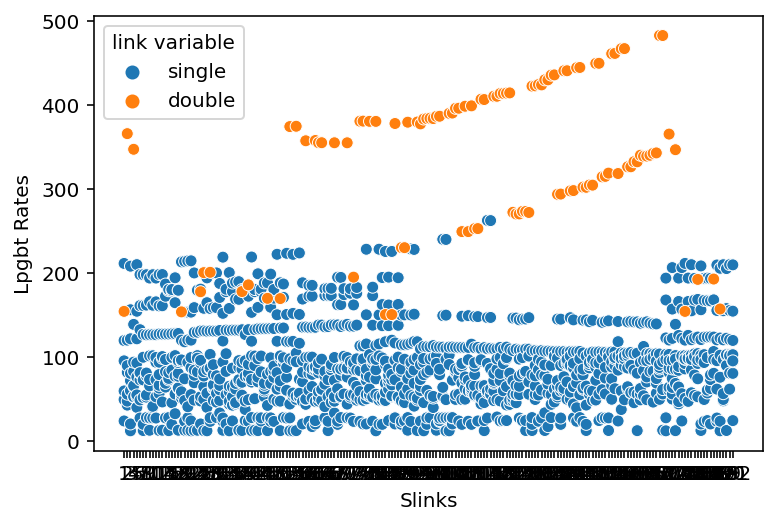

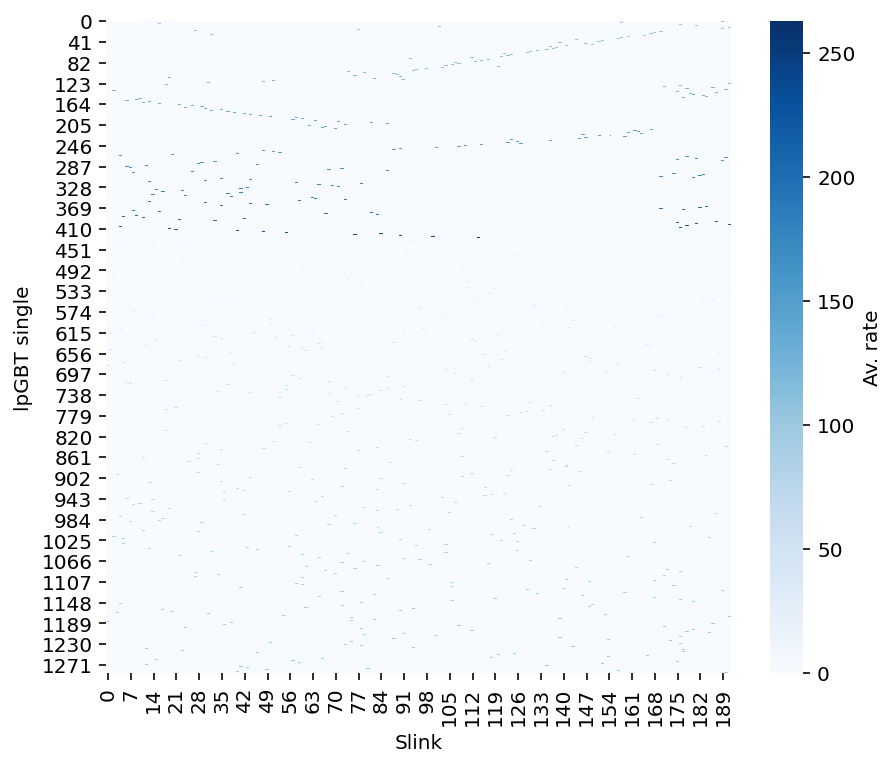

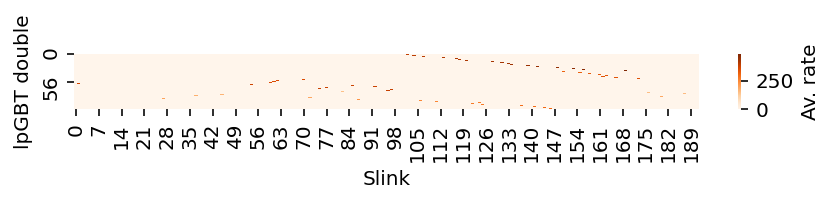

In [26]:
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
''''for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)'''
    
    
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKSingles'+dictNo
    for k in Single1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)

for pNo in range(1,9):
    dictNo='2'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKDoubles'+dictNo
    for k in Double1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single.append(a)
hml2_single=np.array([hml_temp_single])

hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double.append(a)
hml2_double=np.array([hml_temp_double])

df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()
#plt.savefig("Swap_Total scatterplot low600 of 28.png")
   

###SİNGLE PART

(wd, ht) = (7, 6)
vmax = max(singleGBTRatesMAIN)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (singles.T * singleGBTRatesMAIN).T,
    cmap='Blues', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT single')

### DOUBLE PART

f, ax = plt.subplots(figsize=(wd, ht * (nGBTDoubles/nGBTSingles)))
vmax = max(doubleGBTRatesMAIN)
sns.heatmap(
    ((doubles.T) * doubleGBTRatesMAIN).T,
    cmap='Oranges', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT double')

### DATAFRAME PART

def create_dataframe():
    hml_double=(doubles.T*doubleGBTRatesMAIN).T
    hml_single=(singles.T * singleGBTRatesMAIN).T
    a=[]
    #slink_lpgbt_total_list=[]
    #slink_lpgbt_total_list2=[]
    for j in range(nSlinks):
        sum_low=0
        sum_mid=0
        sum_high=0
        sum_doub_low=0
        sum_doub_mid=0
        sum_doub_high=0
        list=[]
     
        for i in hml_single[:,j]:
            if i in lowS.values():
                sum_low+=1
        list.append(sum_low)
        for i in hml_single[:,j]:
            if i in medS.values():
                sum_mid+=1
        list.append(sum_mid)
        for i in hml_single[:,j]:
            if i in highS.values():
                sum_high+=1
        list.append(sum_high)
        for i in hml_double[:,j]:
            if i in lowD.values():
                sum_doub_low+=2
        list.append(sum_doub_low)
        for i in hml_double[:,j]:
            if i in medD.values():
                sum_doub_mid+=2
        list.append(sum_doub_mid)
        for i in hml_double[:,j]:
            if i in highD.values():
                sum_doub_high+=2
        list.append(sum_doub_high)
        list.append(int(slink_rate_list[j]))
        slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
        list.append(slink_lpgbt_total)
        #slink_lpgbt_total_list.append([slink_lpgbt_total])
        #slink_lpgbt_total_list2.append(slink_lpgbt_total)

        a.append(list)
    b=np.array(a)
    c=b.T
    tablo=pd.DataFrame(c,index=["Single Low","Single Mid","Single High","Double Low","Double Mid","Double High","Total Rate","Slink Total lpGBT"],
                          columns=["Slink"+str(i+1) for i in range(nSlinks)])
    tablo.index.name="lpgbt Rates"

    return tablo
    #return slink_lpgbt_total_list2
    #return slink_lpgbt_total_list
create_dataframe()#to_csv('lpGBT_Work_Swap_dataframe.csv')


In [27]:
lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][:int(nGBTDoubles/3)].to_dict()
#medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][-1*int(nGBTDoubles/3):].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ].set_index('DAQlpGBT')["EvSize"][int(nGBTDoubles/3):-1*int(nGBTDoubles/3)].to_dict()
print(len(lowD)+len(medD)+len(highD))

#

110


In [28]:
###   slink_lpgbt_total_list work  ###
slink_lpgbt_total_list=[]
slink_lpgbt_total_list2=[]
for j in range(nSlinks):
    sum_low=0
    sum_mid=0
    sum_high=0
    sum_doub_low=0
    sum_doub_mid=0
    sum_doub_high=0
    list=[]
     
    for i in hml_single[:,j]:
        if i in lowS.values():
            sum_low+=1
    list.append(sum_low)
    for i in hml_single[:,j]:
        if i in medS.values():
            sum_mid+=1
    list.append(sum_mid)
    for i in hml_single[:,j]:
        if i in highS.values():
            sum_high+=1
    list.append(sum_high)
    for i in hml_double[:,j]:
        if i in lowD.values():
            sum_doub_low+=2
    list.append(sum_doub_low)
    for i in hml_double[:,j]:
        if i in medD.values():
            sum_doub_mid+=2
    list.append(sum_doub_mid)
    for i in hml_double[:,j]:
        if i in highD.values():
            sum_doub_high+=2
    #list.append(sum_doub_high)
    #list.append(int(slink_rate_list[j]))
    slink_lpgbt_total=sum_low+sum_mid+sum_high+sum_doub_low+sum_doub_mid+sum_doub_high
    #list.append(slink_lpgbt_total)
    slink_lpgbt_total_list.append([slink_lpgbt_total])
    slink_lpgbt_total_list2.append(slink_lpgbt_total)
    


In [29]:
sum2_lpgbt=0
for i in slink_lpgbt_total_list2:
    
    sum2_lpgbt+=i
sum2_lpgbt


1508

In [30]:
len(highD)

36

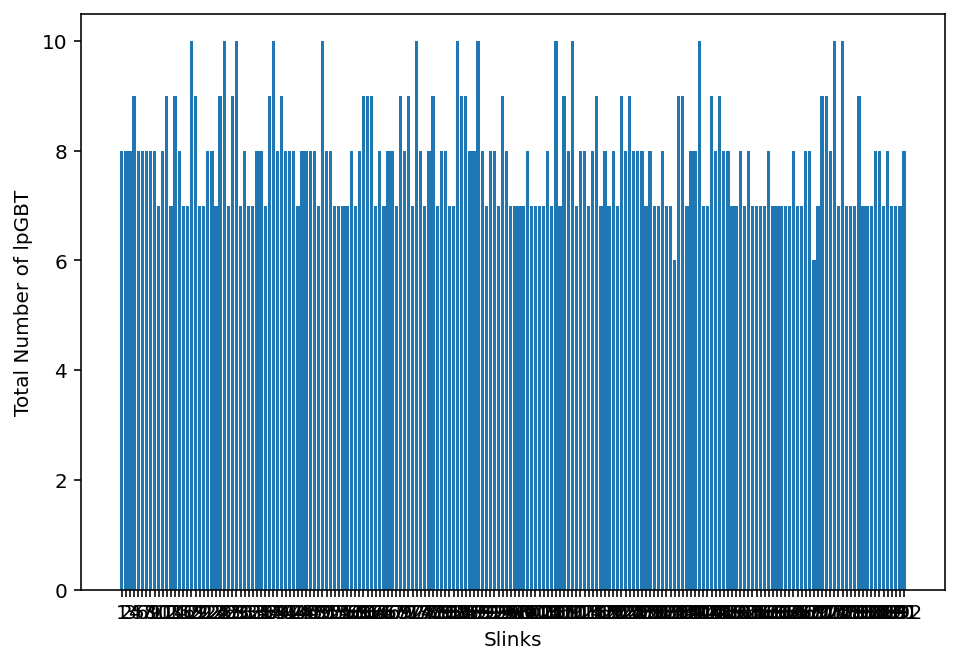

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
Slinks=[str(i) for i in range(1,nSlinks+1)]
lpGBTs = slink_lpgbt_total_list2
ax.set_ylabel('Total Number of lpGBT')
ax.set_xlabel("Slinks")
ax.bar(Slinks,lpGBTs)
#plt.savefig("New Total Number of lpGBT vs Slinks.png")
plt.show()


<BarContainer object of 192 artists>

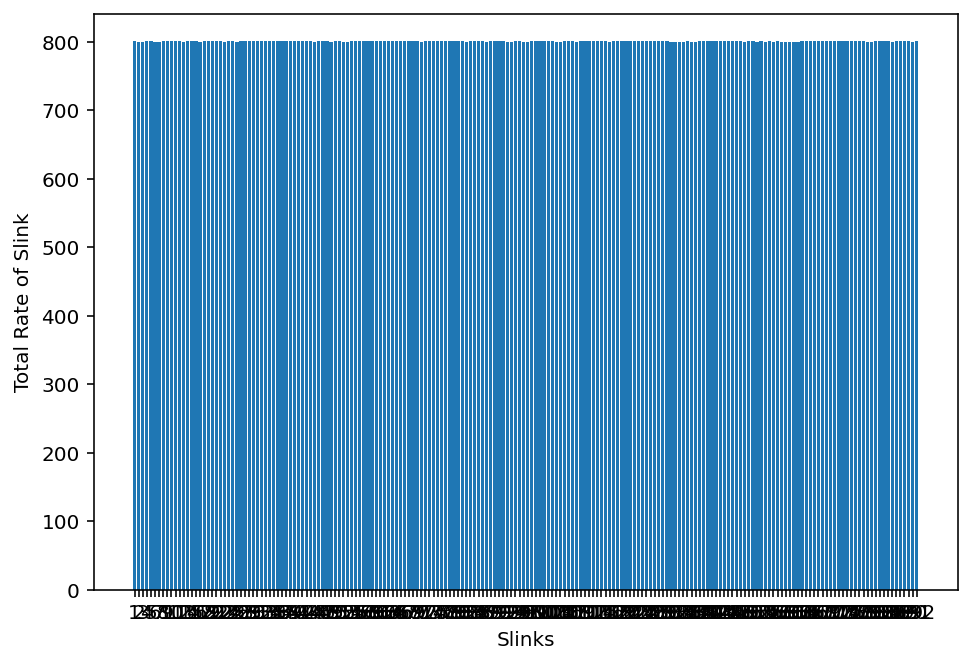

In [32]:
##### Slink Rate vs Slinks
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
Slinks=[str(i) for i in range(1,nSlinks+1)]
Slink_Rates = slink_rate_list
ax.set_ylabel('Total Rate of Slink')
ax.set_xlabel("Slinks")
ax.bar(Slinks,Slink_Rates)
#plt.savefig("New Total Rate of Slink vs Slinks.png",format="png")
#plt.show()


In [24]:

GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
    
#fpga_rate_list



In [25]:
GK2

{'1': 9522.17027,
 '2': 9655.417739999999,
 '3': 9635.38089,
 '4': 9600.091970000001,
 '5': 9549.379009999999,
 '6': 9606.28707,
 '7': 9581.78189,
 '8': 9564.70097,
 '9': 9670.863379999999,
 '10': 9605.159609999999,
 '11': 9549.2521,
 '12': 9524.610240000002,
 '13': 9678.50734,
 '14': 9651.846909999998,
 '15': 9663.66937,
 '16': 9633.641920000002}

/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


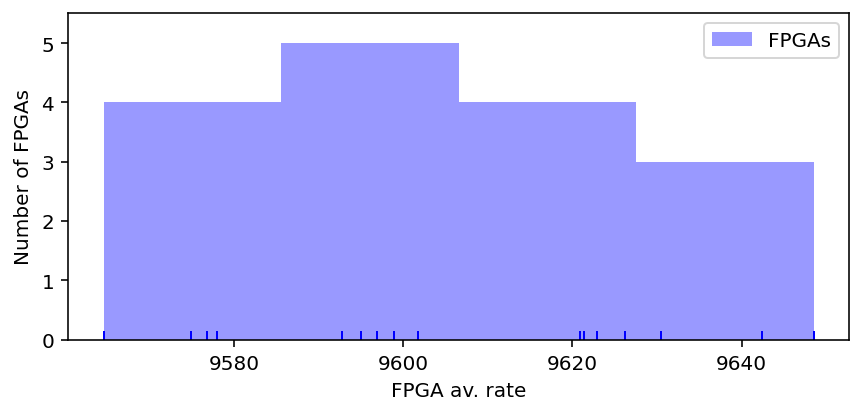

In [75]:

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')
plt.savefig("16 FPGA rate plot after old swap.png")

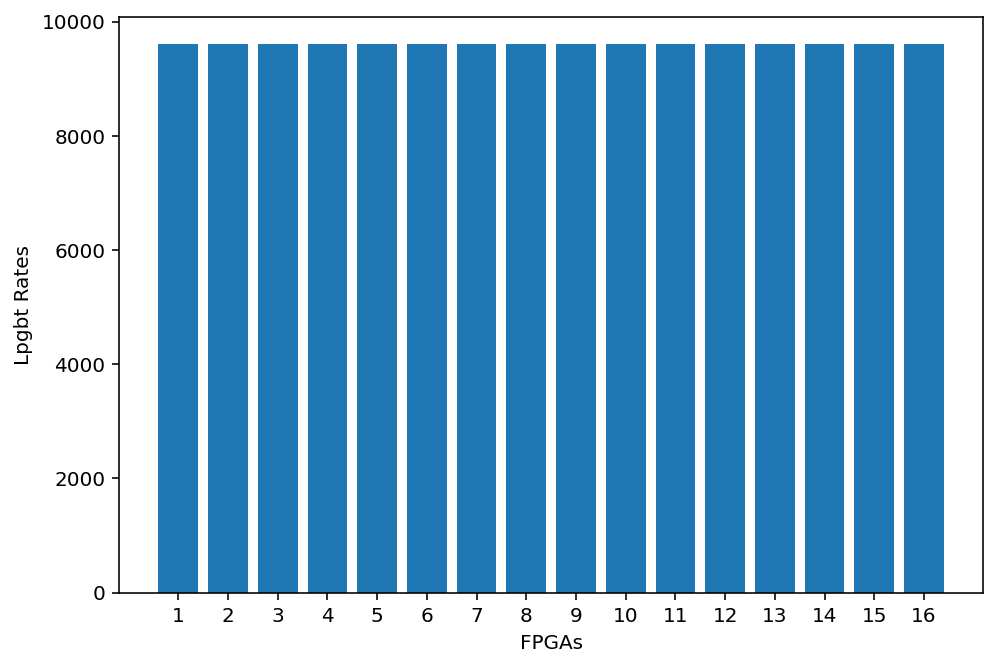

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
FPGAs=[str(i) for i in range(1,nFPGA+1)]
Rates = fpga_rate_list
ax.set_ylabel('Lpgbt Rates')
ax.set_xlabel("FPGAs")
ax.bar(FPGAs,Rates)
#plt.savefig("New Total Rate histogram of Fpga.png")
plt.show()



In [37]:
GK_lpGBT={}
for j in FPGA:
    GK_lpGBT[j] = sum([ slink_lpgbt_total_list2[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_lpGBT_list=[]
for j in GK_lpGBT:
    fpga_lpGBT_list.append(GK_lpGBT[j])
sum_lpgbt=0
for i in fpga_lpGBT_list:
    sum_lpgbt+=i
sum_lpgbt
    

1508.0

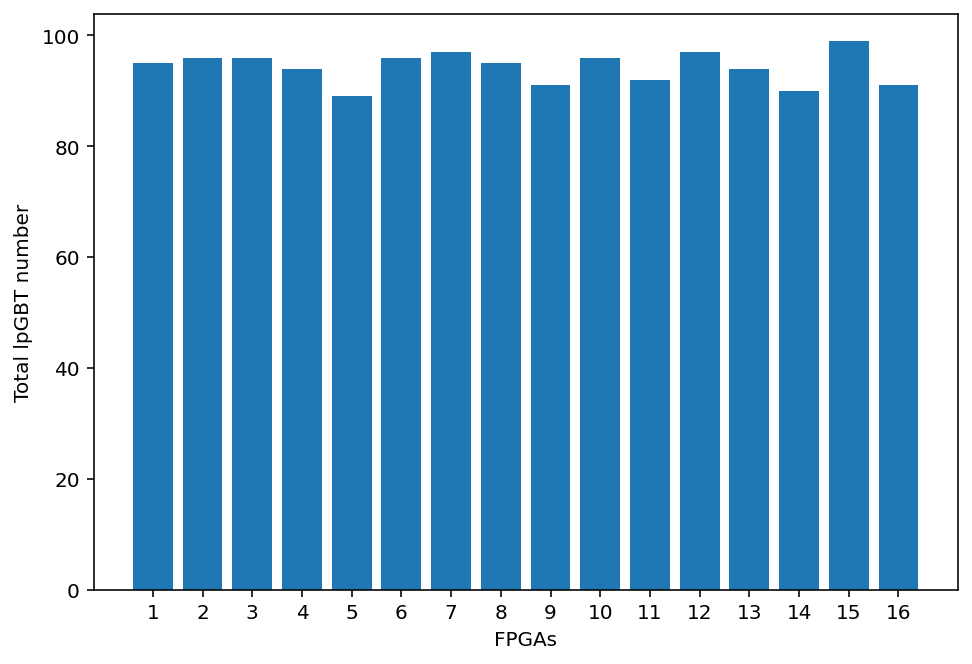

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
FPGAs=[str(i) for i in range(1,nFPGA+1)]
lpGBTs = fpga_lpGBT_list
ax.set_ylabel('Total lpGBT number')
ax.set_xlabel("FPGAs")
ax.bar(FPGAs,lpGBTs)
#plt.savefig("New Total lpGBT Number of Fpgas.png")
plt.show()


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


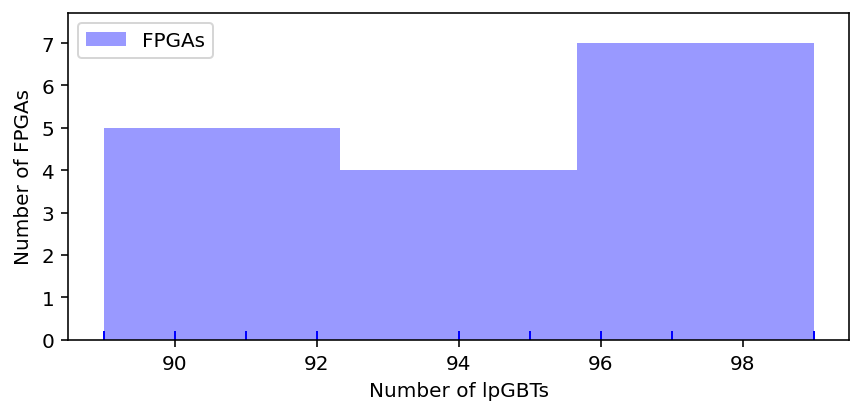

In [75]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_lpGBT_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Number of lpGBTs', ylabel='Number of FPGAs')
plt.savefig("16 FPGA lpgbt number after final swap.png")

In [40]:
fpga_lpgbt_dict={}
for i in FPGA:
    fpga_lpgbt_dict[i]=fpga_lpGBT_list[int(i)-1]
fpga_lpgbt_dict
slink_lpgbt_dict={}
for i in Slink:
    slink_lpgbt_dict[i]=slink_lpgbt_total_list2[int(i)-1]
slink_lpgbt_dict

{'1': 95.0,
 '2': 96.0,
 '3': 96.0,
 '4': 94.0,
 '5': 89.0,
 '6': 96.0,
 '7': 97.0,
 '8': 95.0,
 '9': 91.0,
 '10': 96.0,
 '11': 92.0,
 '12': 97.0,
 '13': 94.0,
 '14': 90.0,
 '15': 99.0,
 '16': 91.0}

In [41]:
slink_lpgbt_dict={}
for i in Slink:
    slink_lpgbt_dict[i]=slink_lpgbt_total_list2[int(i)-1]
slink_lpgbt_dict

{'1': 8,
 '2': 8,
 '3': 8,
 '4': 9,
 '5': 8,
 '6': 8,
 '7': 8,
 '8': 8,
 '9': 8,
 '10': 7,
 '11': 8,
 '12': 9,
 '13': 7,
 '14': 9,
 '15': 8,
 '16': 7,
 '17': 7,
 '18': 10,
 '19': 9,
 '20': 7,
 '21': 7,
 '22': 8,
 '23': 8,
 '24': 7,
 '25': 9,
 '26': 10,
 '27': 7,
 '28': 9,
 '29': 10,
 '30': 7,
 '31': 8,
 '32': 7,
 '33': 7,
 '34': 8,
 '35': 8,
 '36': 7,
 '37': 9,
 '38': 10,
 '39': 8,
 '40': 9,
 '41': 8,
 '42': 8,
 '43': 8,
 '44': 7,
 '45': 8,
 '46': 8,
 '47': 8,
 '48': 8,
 '49': 7,
 '50': 10,
 '51': 8,
 '52': 8,
 '53': 7,
 '54': 7,
 '55': 7,
 '56': 7,
 '57': 8,
 '58': 7,
 '59': 8,
 '60': 9,
 '61': 9,
 '62': 9,
 '63': 7,
 '64': 8,
 '65': 7,
 '66': 8,
 '67': 8,
 '68': 7,
 '69': 9,
 '70': 8,
 '71': 9,
 '72': 7,
 '73': 10,
 '74': 8,
 '75': 7,
 '76': 8,
 '77': 9,
 '78': 7,
 '79': 8,
 '80': 8,
 '81': 7,
 '82': 7,
 '83': 10,
 '84': 9,
 '85': 9,
 '86': 8,
 '87': 8,
 '88': 10,
 '89': 8,
 '90': 7,
 '91': 8,
 '92': 8,
 '93': 7,
 '94': 9,
 '95': 8,
 '96': 7,
 '97': 7,
 '98': 7,
 '99': 7,
 '100': 8,


In [42]:
FPGA_temp=[]
for i in range(1,29):
    FPGA_temp.append(str(i))
FPGA_temp

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28']

In [43]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97': 3

In [44]:
#### LPGBT +ID WORK   #### LPGBT RATE PART
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKSingles'+dictNo
    for k in Single1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)

for pNo in range(1,9):
    dictNo='2'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKDoubles'+dictNo
    for k in Double1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single_RATE.append(a)
hml2_single=np.array([hml_temp_single_RATE])

hml_temp_double_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double_RATE.append(a)
hml2_double=np.array([hml_temp_double_RATE])
hml_temp_double_RATE


1
1
2
3
4
5
6
7
8
1
2
1


<ipython-input-44-745e94a206ec>:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single_RATE])
<ipython-input-44-745e94a206ec>:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double_RATE])


[[154.5439],
 [366.3132],
 [],
 [347.669],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [153.937],
 [],
 [],
 [],
 [],
 [],
 [177.91719999999998],
 [200.6861],
 [],
 [201.0758],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [178.1644],
 [],
 [186.1277],
 [],
 [],
 [],
 [],
 [],
 [170.0694],
 [],
 [],
 [],
 [169.7657],
 [],
 [],
 [374.7344],
 [],
 [375.1077],
 [],
 [],
 [357.8139],
 [],
 [],
 [358.14390000000003],
 [355.5475],
 [355.5097],
 [],
 [],
 [],
 [355.4363],
 [],
 [],
 [],
 [355.4081],
 [],
 [195.29819999999998],
 [],
 [381.1565],
 [381.24199999999996],
 [],
 [380.987],
 [],
 [380.9151],
 [],
 [],
 [150.7394],
 [],
 [150.71790000000001],
 [378.3944],
 [],
 [230.55130000000003],
 [230.4247],
 [379.9456],
 [],
 [],
 [380.15389999999996],
 [377.9358],
 [383.7639],
 [384.31600000000003],
 [384.6464],
 [384.2873],
 [386.87809999999996],
 [387.0361],
 [],
 [],
 [390.49379999999996],
 [390.85830000000004],
 [396.479],
 [396.58900000000006],
 [249.597500000000

In [45]:
#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)

for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKSingles'+dictNo
    for k in Single1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
    


for pNo in range(1,9):
    dictNo='2'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]

double_array=[]
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKDoubles'+dictNo
    for k in Double1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
#sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()

1
1
2
3
4
5
6
7
8
1
2
1


<ipython-input-45-4e961c83298f>:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-45-4e961c83298f>:124: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [48]:
###### ID AND LPGBT RATES TOGETHER #### +++++ SWAPPED FPGA SSS






#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    

            
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKSingles'+dictNo
    for k in Single1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)

for pNo in range(1,9):
    dictNo='2'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]



            
for pNo in [1]:#range(1,3):
    dictNo='1'
    print(pNo)
    name='GKDoubles'+dictNo
    for k in Double1:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                double_array.append(list)
            
            
            
            
            
            
            
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i],"lpGBT Rates":hml_temp_double_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Id":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i]),"lpGBT Rates":hml_temp_single_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)

1
1
2
3
4
5
6
7
8
1
2
1


<ipython-input-48-2cda70a591e1>:135: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-48-2cda70a591e1>:141: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [49]:
#df_together.to_csv("312 even.csv")
df_together

,Slinks,Lpgbt Id,link variable,Total lpGBT of Slinks,total rate,lpGBT Rates,FPGA,Total lpGBT of FPGA,Total Rate of FPGA
0,1,49,single,8.0,800.61305,119.84720,15.0,99.0,9604.83317
1,1,72,single,8.0,800.61305,211.62750,15.0,99.0,9604.83317
2,1,1430,single,8.0,800.61305,23.94330,15.0,99.0,9604.83317
3,1,718,single,8.0,800.61305,49.43460,15.0,99.0,9604.83317
4,1,1242,single,8.0,800.61305,59.71020,15.0,99.0,9604.83317
5,1,390,single,8.0,800.61305,95.57510,15.0,99.0,9604.83317
6,2,242,single,8.0,800.17754,120.31110,12.0,97.0,9606.32338
7,2,729,single,8.0,800.17754,42.83180,12.0,97.0,9606.32338
8,2,1088,single,8.0,800.17754,47.59330,12.0,97.0,9606.32338
9,2,1164,single,8.0,800.17754,55.82515,12.0,97.0,9606.32338


In [50]:
Vars

{'GKSingles1': [['364',
   '712',
   '775',
   '774',
   '703',
   '366',
   '616',
   '617',
   '1024',
   '1025',
   '1010',
   '1011',
   '333',
   '330',
   '331',
   '542',
   '543',
   '332',
   '1119',
   '1116',
   '727',
   '725',
   '759',
   '757',
   '217',
   '648',
   '649',
   '638',
   '216',
   '373',
   '639',
   '372',
   '914',
   '915',
   '553',
   '552',
   '969',
   '26',
   '970',
   '27',
   '956',
   '955',
   '457',
   '455',
   '454',
   '456',
   '663',
   '241',
   '661',
   '240',
   '695',
   '693',
   '482',
   '510',
   '511',
   '585',
   '483',
   '584',
   '574',
   '575',
   '981',
   '982',
   '901',
   '900',
   '927',
   '928',
   '489',
   '488',
   '597',
   '599',
   '426',
   '427',
   '309',
   '629',
   '631',
   '303',
   '308',
   '302',
   '520',
   '521',
   '884',
   '883',
   '448',
   '251',
   '419',
   '983',
   '250',
   '449',
   '418',
   '397',
   '403',
   '402',
   '395',
   '394',
   '396',
   '153',
   '152',
   '273',
  

In [ ]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
        

In [54]:
L3





{1378: 12.189,
 1380: 12.1951,
 1382: 12.1958,
 1379: 12.1976,
 1384: 12.1992,
 1386: 12.2023,
 1387: 12.2093,
 1377: 12.2107,
 1385: 12.2131,
 1381: 12.2151,
 1376: 12.2246,
 1383: 12.2254,
 1366: 12.3632,
 1369: 12.3748,
 1368: 12.3769,
 1367: 12.3806,
 1365: 12.3828,
 1370: 12.3908,
 1372: 12.3921,
 1371: 12.3953,
 1373: 12.3994,
 1375: 12.4002,
 1374: 12.4012,
 1364: 12.4063,
 1354: 12.5755,
 1357: 12.5762,
 1362: 12.5774,
 1353: 12.5776,
 1356: 12.5809,
 1359: 12.5811,
 1355: 12.5839,
 1363: 12.5873,
 1358: 12.5907,
 1352: 12.5923,
 1360: 12.5927,
 1361: 12.6002,
 1350: 12.8867,
 1347: 12.8894,
 1346: 12.8947,
 1341: 12.8978,
 1351: 12.9001,
 1343: 12.9046,
 1344: 12.9048,
 1342: 12.9065,
 1348: 12.9106,
 1340: 12.9137,
 1345: 12.9169,
 1349: 12.9256,
 1114: 17.2101,
 1157: 17.2284,
 1402: 19.8778,
 1408: 19.8935,
 1409: 19.8945,
 1405: 19.8996,
 1401: 19.9019,
 1411: 19.9093,
 1403: 19.9098,
 1410: 19.9105,
 1404: 19.9125,
 1407: 19.9135,
 1400: 19.9139,
 1406: 19.918,
 1396: 20.

In [52]:
GK

{'1': 800.6130499999999,
 '2': 800.1775399999999,
 '3': 799.6519099999999,
 '4': 800.8752000000001,
 '5': 800.6839200000001,
 '6': 800.0164500000001,
 '7': 800.1809,
 '8': 800.7106199999998,
 '9': 800.7317499999999,
 '10': 800.4968400000001,
 '11': 800.7646,
 '12': 800.78525,
 '13': 800.11124,
 '14': 800.66613,
 '15': 800.5096699999999,
 '16': 800.7243400000001,
 '17': 799.0615,
 '18': 800.66833,
 '19': 800.4729,
 '20': 800.84776,
 '21': 800.5009,
 '22': 800.70834,
 '23': 799.9251,
 '24': 800.55324,
 '25': 800.7296999999999,
 '26': 799.74458,
 '27': 800.3720999999999,
 '28': 800.7816,
 '29': 800.8685,
 '30': 800.633,
 '31': 800.8443299999999,
 '32': 800.6766,
 '33': 800.8455499999999,
 '34': 800.76228,
 '35': 800.3209499999999,
 '36': 800.6623,
 '37': 800.85899,
 '38': 800.87165,
 '39': 800.7973999999999,
 '40': 800.4766099999999,
 '41': 800.8315000000001,
 '42': 800.5557999999999,
 '43': 800.80676,
 '44': 800.5245100000001,
 '45': 800.01924,
 '46': 800.7249,
 '47': 800.32335,
 '48': 8

In [55]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

In [65]:
swapData()

{'1': [800.6130499999999,
  [[49, 119.8472],
   [72, 211.6275],
   [822, 154.5439],
   [313, 101.2986],
   [1111, 92.62469999999999],
   [1290, 72.91685],
   [623, 47.7543]]],
 '2': [800.1775399999999,
  [[242, 120.31110000000001],
   [100, 366.3132],
   [1293, 85.0109],
   [1265, 65.7271],
   [1238, 83.0237],
   [1127, 56.13824],
   [1446, 23.6533]]],
 '3': [799.65191,
  [[114, 121.8688],
   [696, 156.4832],
   [594, 208.39139999999998],
   [1221, 72.94156],
   [672, 78.8171],
   [952, 79.38565000000001],
   [1477, 27.7127],
   [659, 54.0515]]],
 '4': [800.8752000000001,
  [[90, 139.02839999999998],
   [374, 347.669],
   [1225, 82.4779],
   [453, 89.8592],
   [1114, 17.2101],
   [1457, 23.4272],
   [531, 58.2883],
   [731, 42.9151]]],
 '5': [800.6839200000001,
  [[115, 121.8416],
   [141, 154.6888],
   [356, 210.23329999999999],
   [611, 80.54759999999999],
   [743, 91.08482],
   [972, 65.8061],
   [1336, 48.762],
   [1481, 27.7197]]],
 '6': [800.0164500000001,
  [[23, 132.6999],
   [

In [60]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1,L2):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

swapData()
ss = [i for i in {k: v for k, v in sorted(swapData().items(), key=lambda item: item[1],reverse=True)}.items()]
print(ss)

[('4', [800.8752000000001, [[90, 139.02839999999998], [374, 347.669], [1225, 82.4779], [453, 89.8592], [1114, 17.2101], [1457, 23.4272], [531, 58.2883], [731, 42.9151]]]), ('176', [800.8749, [[18, 122.45580000000001], [733, 157.2554], [472, 206.69279999999998], [837, 100.04249999999999], [802, 93.61270000000002], [462, 58.948499999999996], [1198, 61.8672]]]), ('38', [800.87165, [[21, 132.6581], [207, 180.58870000000002], [876, 178.1644], [861, 84.53665000000001], [610, 80.6271], [1207, 63.634], [1507, 27.4481], [1377, 12.2107], [849, 41.0039]]]), ('65', [800.8685700000001, [[1081, 136.3683], [724, 173.66500000000002], [509, 181.8423], [640, 82.7116], [925, 93.18900000000001], [677, 92.99828], [1041, 40.09409]]]), ('29', [800.8685, [[218, 131.0647], [239, 159.0196], [200, 200.25310000000002], [1029, 77.69229999999999], [644, 99.4075], [1376, 12.2246], [1389, 20.3743], [1443, 23.6526], [808, 52.768], [1412, 24.4118]]]), ('90', [800.8679999999999, [[458, 115.48100000000001], [6, 379.9456]

In [85]:
for k,v in swapData().items():
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


In [63]:
ss[1][0]

'176'

In [66]:
GK

{'1': 800.6130499999999,
 '2': 800.1775399999999,
 '3': 799.6519099999999,
 '4': 800.8752000000001,
 '5': 800.6839200000001,
 '6': 800.0164500000001,
 '7': 800.1809,
 '8': 800.7106199999998,
 '9': 800.7317499999999,
 '10': 800.4968400000001,
 '11': 800.7646,
 '12': 800.78525,
 '13': 800.11124,
 '14': 800.66613,
 '15': 800.5096699999999,
 '16': 800.7243400000001,
 '17': 799.0615,
 '18': 800.66833,
 '19': 800.4729,
 '20': 800.84776,
 '21': 800.5009,
 '22': 800.70834,
 '23': 799.9251,
 '24': 800.55324,
 '25': 800.7296999999999,
 '26': 799.74458,
 '27': 800.3720999999999,
 '28': 800.7816,
 '29': 800.8685,
 '30': 800.633,
 '31': 800.8443299999999,
 '32': 800.6766,
 '33': 800.8455499999999,
 '34': 800.76228,
 '35': 800.3209499999999,
 '36': 800.6623,
 '37': 800.85899,
 '38': 800.87165,
 '39': 800.7973999999999,
 '40': 800.4766099999999,
 '41': 800.8315000000001,
 '42': 800.5557999999999,
 '43': 800.80676,
 '44': 800.5245100000001,
 '45': 800.01924,
 '46': 800.7249,
 '47': 800.32335,
 '48': 8

In [ ]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1,L2):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
        #ilist -- o vars object için yani run için  GKsingles 2_3  mesela ayrılmış lpgbt rate id ler
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])

f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

In [86]:
slink_total_rate_dict={}
for j in Slink:
    slink_total_rate_dict[j]=0
    for ilist,var in zip(L1,L2):
        slink_total_rate_dict[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
slink_total_rate_dict

{'1': 800.6130499999999,
 '2': 800.1775399999999,
 '3': 799.6519099999999,
 '4': 800.8752000000001,
 '5': 800.6839200000001,
 '6': 800.0164500000001,
 '7': 800.1809,
 '8': 800.7106199999998,
 '9': 800.7317499999999,
 '10': 800.4968400000001,
 '11': 800.7646,
 '12': 800.78525,
 '13': 800.11124,
 '14': 800.66613,
 '15': 800.5096699999999,
 '16': 800.7243400000001,
 '17': 799.0615,
 '18': 800.66833,
 '19': 800.4729,
 '20': 800.84776,
 '21': 800.5009,
 '22': 800.70834,
 '23': 799.9251,
 '24': 800.55324,
 '25': 800.7296999999999,
 '26': 799.74458,
 '27': 800.3720999999999,
 '28': 800.7816,
 '29': 800.8685,
 '30': 800.633,
 '31': 800.8443299999999,
 '32': 800.6766,
 '33': 800.8455499999999,
 '34': 800.76228,
 '35': 800.3209499999999,
 '36': 800.6623,
 '37': 800.85899,
 '38': 800.87165,
 '39': 800.7973999999999,
 '40': 800.4766099999999,
 '41': 800.8315000000001,
 '42': 800.5557999999999,
 '43': 800.80676,
 '44': 800.5245100000001,
 '45': 800.01924,
 '46': 800.7249,
 '47': 800.32335,
 '48': 8

In [108]:
slink_connected_lpgbt_id_dict={}
for j in Slink:
    connected_lpgbt_id_list=[]
    #slink_total_rate_dict[j]=0
    for ilist,var in zip(L1,L2):
        if  (L3[int(i)]*var[i, j].value for i in ilist ) != 0:
            connected_lpgbt_id_list.append(L3[i])
    slink_connected_lpgbt_id_dict[j]=connected_lpgbt_id_list

TypeError: unhashable type: 'list'

In [114]:
slink_connected_lpgbt_id_dict={}


In [109]:
ss


[('4',
  [800.8752000000001,
   [[90, 139.02839999999998],
    [374, 347.669],
    [1225, 82.4779],
    [453, 89.8592],
    [1114, 17.2101],
    [1457, 23.4272],
    [531, 58.2883],
    [731, 42.9151]]]),
 ('176',
  [800.8749,
   [[18, 122.45580000000001],
    [733, 157.2554],
    [472, 206.69279999999998],
    [837, 100.04249999999999],
    [802, 93.61270000000002],
    [462, 58.948499999999996],
    [1198, 61.8672]]]),
 ('38',
  [800.87165,
   [[21, 132.6581],
    [207, 180.58870000000002],
    [876, 178.1644],
    [861, 84.53665000000001],
    [610, 80.6271],
    [1207, 63.634],
    [1507, 27.4481],
    [1377, 12.2107],
    [849, 41.0039]]]),
 ('65',
  [800.8685700000001,
   [[1081, 136.3683],
    [724, 173.66500000000002],
    [509, 181.8423],
    [640, 82.7116],
    [925, 93.18900000000001],
    [677, 92.99828],
    [1041, 40.09409]]]),
 ('29',
  [800.8685,
   [[218, 131.0647],
    [239, 159.0196],
    [200, 200.25310000000002],
    [1029, 77.69229999999999],
    [644, 99.4075],
 

In [113]:
ss[0][0]

'4'

In [134]:
for i in ss:
    print(i)
    

('4', [800.8752000000001, [[90, 139.02839999999998], [374, 347.669], [1225, 82.4779], [453, 89.8592], [1114, 17.2101], [1457, 23.4272], [531, 58.2883], [731, 42.9151]]])
('176', [800.8749, [[18, 122.45580000000001], [733, 157.2554], [472, 206.69279999999998], [837, 100.04249999999999], [802, 93.61270000000002], [462, 58.948499999999996], [1198, 61.8672]]])
('38', [800.87165, [[21, 132.6581], [207, 180.58870000000002], [876, 178.1644], [861, 84.53665000000001], [610, 80.6271], [1207, 63.634], [1507, 27.4481], [1377, 12.2107], [849, 41.0039]]])
('65', [800.8685700000001, [[1081, 136.3683], [724, 173.66500000000002], [509, 181.8423], [640, 82.7116], [925, 93.18900000000001], [677, 92.99828], [1041, 40.09409]]])
('29', [800.8685, [[218, 131.0647], [239, 159.0196], [200, 200.25310000000002], [1029, 77.69229999999999], [644, 99.4075], [1376, 12.2246], [1389, 20.3743], [1443, 23.6526], [808, 52.768], [1412, 24.4118]]])
('90', [800.8679999999999, [[458, 115.48100000000001], [6, 379.9456], [711

In [128]:
slink_lpgbt_rate_dict={}

In [ ]:
    highC=0
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=ss[highC] #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]

        for l in slinkHigh[1][1]:

                #print(l)
            for k in slinkLow[1][1]:
                    
                if abs(float(l[1])-float(k[1]))<dif/2 and float(l[1])>float(k[1]): #and abs(GKavSlinkRate-abs(float(l[1])-float(k[1])))<temp_best:
                   
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==0:
            lowC-=1
                
            #lowC-=1
            #slinkLow=ss[lowC]
        if flag==1:
            #lowC=temp_low
            highC+=1
            lowC-=1                      
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
            
            for ilist,var in zip(L1_Swap,L2_Swap): #yeni- Bu for loop diger loop'un icindeydi ve ayni islemi tekrar tekrar yapiyordu.
                if str(lplow) in ilist:
                    var[str(lplow),slinkLow[0]].value=0
                    var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
            
            #ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
            #print("-------------OK--------------")
        #print("-----------------------------")
        #lowC-=1
        

In [142]:
    slink_lpgbt_dict_rate={}
    highC=0
    for i in ss: # i -- slink id s
        #if len(i[1][1])==1:
            #continue
            
        slinkHigh=ss[highC] #[çünkü ss high göre sort edilmiş slink dict]
        #slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
        lpgbt_list=[]

        for l in slinkHigh[1][1]:
            lpgbt_list.append(l[1])
        slink_lpgbt_dict_rate[slinkHigh[0][0]]=lpgbt_list
        highC+=1
            


In [143]:
slink_lpgbt_dict_rate

{'4': [118.958,
  150.5179,
  222.559,
  66.47430000000001,
  91.18293999999999,
  94.57489999999999,
  55.736180000000004],
 '1': [101.8058,
  127.8846,
  164.8545,
  194.5647,
  71.88767,
  88.51992999999999,
  49.5443],
 '3': [121.8688,
  156.4832,
  208.39139999999998,
  72.94156,
  78.8171,
  79.38565000000001,
  27.7127,
  54.0515],
 '6': [132.6999,
  161.3822,
  198.4031,
  80.7346,
  87.3875,
  28.677100000000003,
  54.92275,
  55.8093],
 '2': [131.2462,
  158.2327,
  200.6861,
  78.0308,
  99.662,
  12.4012,
  12.9001,
  49.6001,
  56.98537999999999],
 '9': [112.36529999999999,
  384.31600000000003,
  65.0313,
  98.70120000000001,
  83.03890000000001,
  56.01799],
 '5': [118.7039,
  150.8759,
  223.7453,
  75.96640000000001,
  77.9747,
  84.6689,
  48.2792,
  19.918],
 '8': [137.9587,
  162.7557,
  194.6354,
  65.2912,
  73.68408,
  85.7589,
  19.9093,
  59.7784],
 '7': [139.09290000000001,
  355.4081,
  84.95049999999999,
  90.03130000000002,
  48.4387,
  12.6002,
  12.9046,


In [154]:
highC=0
slink_lpgbt_dict_rate={}
for i in ss: # i -- slink id s
        #if len(i[1][1])==1:
            #continue
    liste=[]       
    slinkHigh=ss[highC]
    for l in slinkHigh[1][1]:
        liste.append(l[1])
    slink_lpgbt_dict_rate[slinkHigh[0][0]]=liste 
    highC+=1


In [155]:
slink_lpgbt_dict_rate

{'4': [118.958,
  150.5179,
  222.559,
  66.47430000000001,
  91.18293999999999,
  94.57489999999999,
  55.736180000000004],
 '1': [101.8058,
  127.8846,
  164.8545,
  194.5647,
  71.88767,
  88.51992999999999,
  49.5443],
 '3': [121.8688,
  156.4832,
  208.39139999999998,
  72.94156,
  78.8171,
  79.38565000000001,
  27.7127,
  54.0515],
 '6': [132.6999,
  161.3822,
  198.4031,
  80.7346,
  87.3875,
  28.677100000000003,
  54.92275,
  55.8093],
 '2': [131.2462,
  158.2327,
  200.6861,
  78.0308,
  99.662,
  12.4012,
  12.9001,
  49.6001,
  56.98537999999999],
 '9': [112.36529999999999,
  384.31600000000003,
  65.0313,
  98.70120000000001,
  83.03890000000001,
  56.01799],
 '5': [118.7039,
  150.8759,
  223.7453,
  75.96640000000001,
  77.9747,
  84.6689,
  48.2792,
  19.918],
 '8': [137.9587,
  162.7557,
  194.6354,
  65.2912,
  73.68408,
  85.7589,
  19.9093,
  59.7784],
 '7': [139.09290000000001,
  355.4081,
  84.95049999999999,
  90.03130000000002,
  48.4387,
  12.6002,
  12.9046,


In [132]:
for j in Slink:
   
    for ilist,var in zip(L1,L2):
        slink_lpgbt_rate_dict[j]=[]
        if int(sum(L3[int(i)]*var[i, j].value for i in ilist)) != 0:
            slink_lpgbt_rate_dict[j].append([ L3[int(i)]*var[i, j].value for i in ilist ])

In [133]:
slink_lpgbt_rate_dict

{'1': [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   47.7543,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,

In [49]:
def total_buffer_of_fpga(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    #return connected_slinks
  
    #for k in connected_slinks:
        #print(slink_lpgbt_dict[k])
    #return connected_slinks
    
    total_buffer=0
    for j in connected_slinks:
        if slink_lpgbt_dict[j]%2==0:
            event=slink_lpgbt_dict[j]/2
            total_buffer+=event
        else:
            event=(slink_lpgbt_dict[j]+1)/2
            total_buffer+=event
    
    return total_buffer
def connected_slinks(fpga):
    connected_slinks=[]
    for i in slinks_to_fpga.keys():
        if slinks_to_fpga[i]==int(fpga):
            connected_slinks.append(i)
    return connected_slinks
    
    

In [50]:
#total_buffer_of_fpga('26')
connected_slinks('15')


['1', '5', '23', '46', '52', '60', '87', '124', '142', '167', '181', '192']

In [51]:
buffer_fpga_dict={}
for fpga in FPGA:
    buffer_fpga_dict[fpga]=total_buffer_of_fpga(fpga)
buffer_fpga_dict
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
buffer_slink_dict={}
for slink in Slinks:
    buffer_slink_dict[slink]=total_buffer_of_slink(slink)
buffer_slink_dict
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga
max_event_buffer=int(total_buffer/nFPGA)
max_event_buffer


#########################################

##### SECONDARY SWAP #### + FPGA TOTAL RATE  burann kodu bu

### NOW SWAP ALGORİTHM FOR FPGA BUFFER after OPTİMİZASYON###
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    if buffer_fpga_dict[fpga]>max_event_buffer:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        #print(fpga1)
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            #highest_buffer_slink=slink
            #break
            if buffer_slink_dict[slink]>temp_slink: 
                temp_slink=buffer_slink_dict[slink]
                highest_buffer_slink=slink
                if GK[slink]<temp_rate:
                    temp_slink=buffer_slink_dict[slink]
                    highest_buffer_slink=slink
                    #print(temp_slink)
                    
                    #temp_rate=GK[slink]
            #else:
                #continue
        #key_value=buffer
        lowest_buffer_fpga=10000
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<max_event_buffer):# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                #print('other fpga:',fpga2)
                #FLAG=1
                
            #else:
                #continue
                
                temp_rate2=100000
                for k in connected_slinks(fpga2_temp):# find the lowest buffer slink in lower buffer fpga 
                    key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                    #key_value=buffer_fpga_dict[fpga1]-30
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])
                    #print('key value ok',key_value)
                    
                    
                    if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                        #buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]>=buffer_fpga_dict[fpga1]-30  and 
                        #temp_slink=buffer_slink_dict[k]
                        #key_value==buffer_fpga_dict[fpga1]-30
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        #if (buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                        lowest_buffer_slink=k
                        temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                        #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                        FLAG=1
                        #print('FLAG:',FLAG)
                        #if GK[k]<temp_rate2:
                            #lowest_buffer_slink=k
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                            #FLAG=1
                            
                        
                    #else:
                        #continue
                        #FLAG=1
        
        
        #now change the slinks
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0
            
            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
        



{'1': 50.0,
 '2': 53.0,
 '3': 52.0,
 '4': 49.0,
 '5': 48.0,
 '6': 52.0,
 '7': 52.0,
 '8': 50.0,
 '9': 50.0,
 '10': 51.0,
 '11': 49.0,
 '12': 50.0,
 '13': 52.0,
 '14': 50.0,
 '15': 51.0,
 '16': 48.0}

In [52]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [53]:
def total_buffer_of_slink(slink):
    if slink_lpgbt_dict[slink]%2==0:
        event=(slink_lpgbt_dict[slink])/2
    else:
        event=(slink_lpgbt_dict[slink]+1)/2
    return event
    

In [54]:
total_buffer_of_slink('150')

4.0

In [55]:
buffer_slink_dict={}
for slink in Slinks:
    buffer_slink_dict[slink]=total_buffer_of_slink(slink)
buffer_slink_dict

{'1': 4.0,
 '2': 4.0,
 '3': 4.0,
 '4': 5.0,
 '5': 4.0,
 '6': 4.0,
 '7': 4.0,
 '8': 4.0,
 '9': 4.0,
 '10': 4.0,
 '11': 4.0,
 '12': 5.0,
 '13': 4.0,
 '14': 5.0,
 '15': 4.0,
 '16': 4.0,
 '17': 4.0,
 '18': 5.0,
 '19': 5.0,
 '20': 4.0,
 '21': 4.0,
 '22': 4.0,
 '23': 4.0,
 '24': 4.0,
 '25': 5.0,
 '26': 5.0,
 '27': 4.0,
 '28': 5.0,
 '29': 5.0,
 '30': 4.0,
 '31': 4.0,
 '32': 4.0,
 '33': 4.0,
 '34': 4.0,
 '35': 4.0,
 '36': 4.0,
 '37': 5.0,
 '38': 5.0,
 '39': 4.0,
 '40': 5.0,
 '41': 4.0,
 '42': 4.0,
 '43': 4.0,
 '44': 4.0,
 '45': 4.0,
 '46': 4.0,
 '47': 4.0,
 '48': 4.0,
 '49': 4.0,
 '50': 5.0,
 '51': 4.0,
 '52': 4.0,
 '53': 4.0,
 '54': 4.0,
 '55': 4.0,
 '56': 4.0,
 '57': 4.0,
 '58': 4.0,
 '59': 4.0,
 '60': 5.0,
 '61': 5.0,
 '62': 5.0,
 '63': 4.0,
 '64': 4.0,
 '65': 4.0,
 '66': 4.0,
 '67': 4.0,
 '68': 4.0,
 '69': 5.0,
 '70': 4.0,
 '71': 5.0,
 '72': 4.0,
 '73': 5.0,
 '74': 4.0,
 '75': 4.0,
 '76': 4.0,
 '77': 5.0,
 '78': 4.0,
 '79': 4.0,
 '80': 4.0,
 '81': 4.0,
 '82': 4.0,
 '83': 5.0,
 '84': 5.0,
 

In [56]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 16,
 '4': 6,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 7,
 '19': 2,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 3,
 '27': 13,
 '28': 7,
 '29': 13,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 10,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97': 3

In [57]:
buffer_fpga_dict

{'1': 50.0,
 '2': 53.0,
 '3': 52.0,
 '4': 49.0,
 '5': 48.0,
 '6': 52.0,
 '7': 52.0,
 '8': 50.0,
 '9': 50.0,
 '10': 51.0,
 '11': 49.0,
 '12': 50.0,
 '13': 52.0,
 '14': 50.0,
 '15': 51.0,
 '16': 48.0}

In [58]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer

807.0

In [59]:
for i in FPGA:
    if model.GKSlinks['132',i]==1:
        print(i)

13


In [60]:
#max_event_buffer=50
max_event_buffer=int(total_buffer/nFPGA)
max_event_buffer

50

In [64]:
##### SECONDARY SWAP #### + FPGA TOTAL RATE  burann kodu bu

### NOW SWAP ALGORİTHM FOR FPGA BUFFER after OPTİMİZASYON###
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    if buffer_fpga_dict[fpga]>max_event_buffer:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        #print(fpga1)
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            #highest_buffer_slink=slink
            #break
            if buffer_slink_dict[slink]>temp_slink: 
                temp_slink=buffer_slink_dict[slink]
                highest_buffer_slink=slink
                if GK[slink]<temp_rate:
                    temp_slink=buffer_slink_dict[slink]
                    highest_buffer_slink=slink
                    #print(temp_slink)
                    
                    #temp_rate=GK[slink]
            #else:
                #continue
        #key_value=buffer
        lowest_buffer_fpga=10000
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga]<max_event_buffer):# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                #print('other fpga:',fpga2)
                #FLAG=1
                
            #else:
                #continue
                
                temp_rate2=100000
                for k in connected_slinks(fpga2_temp):# find the lowest buffer slink in lower buffer fpga 
                    key_value=buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]
                    #key_value=buffer_fpga_dict[fpga1]-30
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])
                    #print('key value ok',key_value)
                    
                    
                    if key_value==1 and key_rate<temp_rate2:#buffer_fpga_dict[fpga1]-key_value<=30 and buffer_fpga_dict[fpga2]+key_value<=30:
                        #buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]>=buffer_fpga_dict[fpga1]-30  and 
                        #temp_slink=buffer_slink_dict[k]
                        #key_value==buffer_fpga_dict[fpga1]-30
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        #if (buffer_fpga_dict[fpga2]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30  and (buffer_fpga_dict[fpga1]+buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k])<=30:
                        lowest_buffer_slink=k
                        temp_rate2=abs(GK[highest_buffer_slink]-GK[lowest_buffer_slink])
                        #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                        FLAG=1
                        #print('FLAG:',FLAG)
                        #if GK[k]<temp_rate2:
                            #lowest_buffer_slink=k
                            #temp_rate2=abs(GK[highest_buffer_slink]-GK[k])
                            #FLAG=1
                            
                        
                    #else:
                        #continue
                        #FLAG=1
        
        
        #now change the slinks
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0
            
            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
        

In [65]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [66]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [67]:
for i in FPGA:
    if model.GKSlinks['132',i]==1:
        print(i)

13


In [68]:
slinks_to_fpga={}
for i in Slinks:
    for j in FPGA:
        if model.GKSlinks[i,j]==1:
            slinks_to_fpga[i]=int(j)
slinks_to_fpga

{'1': 15,
 '2': 12,
 '3': 3,
 '4': 11,
 '5': 15,
 '6': 13,
 '7': 2,
 '8': 1,
 '9': 4,
 '10': 3,
 '11': 7,
 '12': 14,
 '13': 7,
 '14': 6,
 '15': 14,
 '16': 12,
 '17': 13,
 '18': 5,
 '19': 16,
 '20': 3,
 '21': 6,
 '22': 4,
 '23': 15,
 '24': 5,
 '25': 7,
 '26': 16,
 '27': 13,
 '28': 7,
 '29': 4,
 '30': 9,
 '31': 1,
 '32': 14,
 '33': 4,
 '34': 1,
 '35': 8,
 '36': 5,
 '37': 5,
 '38': 3,
 '39': 12,
 '40': 2,
 '41': 16,
 '42': 11,
 '43': 8,
 '44': 5,
 '45': 1,
 '46': 15,
 '47': 16,
 '48': 11,
 '49': 14,
 '50': 10,
 '51': 7,
 '52': 15,
 '53': 2,
 '54': 11,
 '55': 12,
 '56': 8,
 '57': 6,
 '58': 10,
 '59': 3,
 '60': 15,
 '61': 2,
 '62': 6,
 '63': 9,
 '64': 4,
 '65': 16,
 '66': 11,
 '67': 8,
 '68': 14,
 '69': 2,
 '70': 10,
 '71': 9,
 '72': 1,
 '73': 4,
 '74': 5,
 '75': 13,
 '76': 1,
 '77': 12,
 '78': 13,
 '79': 7,
 '80': 11,
 '81': 6,
 '82': 1,
 '83': 10,
 '84': 9,
 '85': 14,
 '86': 6,
 '87': 15,
 '88': 12,
 '89': 2,
 '90': 7,
 '91': 9,
 '92': 16,
 '93': 5,
 '94': 1,
 '95': 12,
 '96': 8,
 '97': 3

In [69]:
buffer_fpga_dict

{'1': 50.0,
 '2': 52.0,
 '3': 51.0,
 '4': 50.0,
 '5': 50.0,
 '6': 51.0,
 '7': 51.0,
 '8': 50.0,
 '9': 50.0,
 '10': 50.0,
 '11': 50.0,
 '12': 50.0,
 '13': 51.0,
 '14': 50.0,
 '15': 51.0,
 '16': 50.0}

In [70]:
key_event=int(total_buffer/nFPGA)+1
key_event


51

In [71]:
''''##### EVENT BUFFER 30 LARI ELE #####
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    
    if buffer_fpga_dict[fpga]>30:
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            highest_buffer_slink=slink
            #break
            #if buffer_slink_dict[slink]>temp_slink: 
                #temp_slink=buffer_slink_dict[slink]
                #highest_buffer_slink=slink
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga])<30: #>int(key_event)) and buffer_fpga_dict[other_fpga]<30:# and buffer_fpga_dict[other_fpga]<lowest_buffer_fpga:
                lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2=other_fpga
        temp_rate=100000       #print('other fpga:',fpga2)
        for k in connected_slinks(fpga2):
            key_rate=abs(GK[highest_buffer_slink]-GK[k])
            
            if buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]==1 and key_rate<temp_rate:
                lowest_buffer_slink=k
                temp_rate=abs(GK[highest_buffer_slink]-GK[k])
                FLAG=1
                
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slinks:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
            
                
                

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-71-5e42f09099e2>, line 51)

In [84]:
key_event=50

In [85]:
##### EVENT BUFFER I ORTALAMAYA YAKLAŞTIR #####
for fpga in FPGA:
    #fpga1=fpga
    FLAG=0
    
    if buffer_fpga_dict[fpga]>int(key_event):
        temp_slink=0
        temp_rate=100000
        fpga1=fpga
        for slink in connected_slinks(fpga1): # find the highest slink in higher fpga.
            highest_buffer_slink=slink
            #break
            #if buffer_slink_dict[slink]>temp_slink: 
                #temp_slink=buffer_slink_dict[slink]
                #highest_buffer_slink=slink
        for other_fpga in FPGA: # find the lowest buffer fpga to change slinks
            #fpga2=other_fpga
            if other_fpga!=fpga1 and (buffer_fpga_dict[other_fpga])<key_event:#==max_event_buffer:#max_event_buffer değiştirilebilir.
                #lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                fpga2_temp=other_fpga
                temp_rate=100000       #print('other fpga:',fpga2)
                for k in connected_slinks(fpga2_temp):
                    key_rate=abs(GK[highest_buffer_slink]-GK[k])

                    if buffer_slink_dict[highest_buffer_slink]-buffer_slink_dict[k]==1 and key_rate<temp_rate:
                        lowest_buffer_slink=k
                        lowest_buffer_fpga=buffer_fpga_dict[other_fpga]
                        fpga2=other_fpga
                        FLAG=1
                
        if FLAG==1:
            model.GKSlinks[highest_buffer_slink,fpga1]=0
            model.GKSlinks[highest_buffer_slink,fpga2]=1
            model.GKSlinks[lowest_buffer_slink,fpga2]=0

            model.GKSlinks[lowest_buffer_slink,fpga1]=1
            print('higher buffer fpga:',fpga1,'its total buffer:',buffer_fpga_dict[fpga1],'RATE:',GK[highest_buffer_slink],'its slinks highest buffer one',highest_buffer_slink,'its total buffer',buffer_slink_dict[highest_buffer_slink])
            print('lower buffer fpga:',fpga2,'its total buffer:',buffer_fpga_dict[fpga2],'RATE:', GK[lowest_buffer_slink],'its slinks lowest buffer one',lowest_buffer_slink,'its total buffer',buffer_slink_dict[lowest_buffer_slink])
            print('----------------')#update_slinks_to_fpga()
            slinks_to_fpga={}
            for i in Slink:
                for j in FPGA:
                    if model.GKSlinks[i,j]==1:
                        slinks_to_fpga[i]=int(j)
            buffer_fpga_dict[fpga1]=total_buffer_of_fpga(fpga1)
            buffer_fpga_dict[fpga2]=total_buffer_of_fpga(fpga2)
            #update_buffer_fpga_dict(fpga1)
            #print(buffer_fpga_dict)
            #update_buffer_fpga_dict(fpga2)
            
                
                

In [86]:
buffer_fpga_dict

{'1': 50.0,
 '2': 53.0,
 '3': 52.0,
 '4': 49.0,
 '5': 48.0,
 '6': 52.0,
 '7': 52.0,
 '8': 50.0,
 '9': 50.0,
 '10': 51.0,
 '11': 49.0,
 '12': 50.0,
 '13': 52.0,
 '14': 50.0,
 '15': 51.0,
 '16': 48.0}

In [87]:
total_buffer=0
for k in buffer_fpga_dict.values():
    total_buffer+=k
total_buffer
    

807.0

In [88]:
GK_lpGBT={}
for j in FPGA:
    GK_lpGBT[j] = sum([ slink_lpgbt_total_list2[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_lpGBT_list=[]
for j in GK_lpGBT:
    fpga_lpGBT_list.append(GK_lpGBT[j])
#fpga_lpGBT_list
fpga_lpgbt_dict={}
for i in FPGA:
    fpga_lpgbt_dict[i]=fpga_lpGBT_list[int(i)-1]
fpga_lpgbt_dict

TypeError: 'int' object is not callable

In [89]:

GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
#for j in FPGA:
    #print(GK2[j])
fpga_rate_list_swap=[]
for j in GK2:
    fpga_rate_list_swap.append(GK2[j])
#fpga_rate_list_swap
GK2

TypeError: 'int' object is not callable

In [77]:
#### LPGBT +ID WORK   #### LPGBT RATE PART
single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in singleGBTRates_1.values():
    s.append(i)
for i in singleGBTRates_2_ALL.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates_1.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single_RATE.append(a)
hml2_single=np.array([hml_temp_single_RATE])

hml_temp_double_RATE=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double_RATE.append(a)
hml2_double=np.array([hml_temp_double_RATE])
hml_temp_double_RATE


1
2
3
4
5
6
7
8
1
2


<ipython-input-77-17ce7cb10a28>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_single=np.array([hml_temp_single_RATE])
<ipython-input-77-17ce7cb10a28>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double_RATE])


[[154.5439],
 [366.3132],
 [],
 [347.669],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [153.937],
 [],
 [],
 [],
 [],
 [],
 [177.91719999999998],
 [200.6861],
 [],
 [201.0758],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [178.1644],
 [],
 [186.1277],
 [],
 [],
 [],
 [],
 [],
 [170.0694],
 [],
 [],
 [],
 [169.7657],
 [],
 [],
 [374.7344],
 [],
 [375.1077],
 [],
 [],
 [357.8139],
 [],
 [],
 [358.14390000000003],
 [355.5475],
 [355.5097],
 [],
 [],
 [],
 [355.4363],
 [],
 [],
 [],
 [355.4081],
 [],
 [195.29819999999998],
 [],
 [381.1565],
 [381.24199999999996],
 [],
 [380.987],
 [],
 [380.9151],
 [],
 [],
 [150.7394],
 [],
 [150.71790000000001],
 [378.3944],
 [],
 [230.55130000000003],
 [230.4247],
 [379.9456],
 [],
 [],
 [380.15389999999996],
 [377.9358],
 [383.7639],
 [384.31600000000003],
 [384.6464],
 [384.2873],
 [386.87809999999996],
 [387.0361],
 [],
 [],
 [390.49379999999996],
 [390.85830000000004],
 [396.479],
 [396.58900000000006],
 [249.597500000000

In [78]:
#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)
#sns_scatter=sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig=sns_scatter.get_figure()

1
2
3
4
5
6
7
8
1
2


<ipython-input-78-7709cc67c55d>:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-78-7709cc67c55d>:115: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [79]:
###### ID AND LPGBT RATES TOGETHER #### +++++ SWAPPED FPGA SSS






#### ID WORK ####

single_array=[]
single_list=[Single1,Single2_dict]
dictNo='2'
names=[]
plot_single2=[]
for pNo in range(8):
    name='GKSingles'+dictNo+'_'+str(pNo)
    names.append(name)
    for i in name:
        plot_single2.append(i)
    
    
for k in Single1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles1[k,j])<=1.0000009:
            list[int(j)-1]=1           
            single_array.append(list)

for pNo in range(1,9):
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
for pNo in [1,2]:#range(1,3):
    dictNo='3'
    print(pNo)
    name='GKSingles'+dictNo+'_'+str(pNo-1)
    for k in Single2_dict[8+pNo]:
        for j in Slink:
            list=[0]*nSlinks
            if 0.9<= Vars[name][1][k, j].value <=1.0000009:#0.9<=pyo.value(model.GKSingles2[k,j])<=1.0000009:
                list[int(j)-1]=1           
                single_array.append(list)
                
                
singles=np.array(single_array)
s=[]
for i in Single1:
    s.append(int(i))
for i in Single2_ALL:
    s.append(int(i))
singleGBTRatesMAIN=np.array(s)
hml_single=(singles.T*singleGBTRatesMAIN).T
#hml_single[:,0]
double_array=[]
for i in Double1:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles1[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in Double1:
    d.append(int(i))
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
#hml_double[:0]

#### SCATTER PLOT PART
hml_temp_single2=[]
hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total=0
    for i in hml_single[:,j]:
        #if 0.9<=pyo.value(model.GKSingles1[0,j])<=1.0000009:
            #b.append(str(0))
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total-=1
        #total+=1
    #if total==len(hml_single[:,j]): 
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_single2.append(a)
    hml_temp_single.append(b)

hml_temp_double2=[]
hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    b=[]
    #total_d=0
    if 0.9<=pyo.value(model.GKDoubles1['0',str(j+1)])<=1.0000009:
        b.append(str(0))
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
            b.append(str(i))
            #total_d-=1
        #total_d+=1
    #if total_d==len(hml_double[:,j]):
        #b.append(str(0))
    #b=np.array(a)
    hml_temp_double2.append(a)
    hml_temp_double.append(b)
hml2_double=np.array([hml_temp_double])


df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame()
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set(rc={'figure.figsize':(11.7,8.27)})e({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_double[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],"Lpgbt Id":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i],"lpGBT Rates":hml_temp_double_RATE[i],"FPGA":slinks_to_fpga[str(i+1)],"Event-Buffer":buffer_fpga_dict[str(slinks_to_fpga[str(i+1)])],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Id":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i+1)]*len(hml_temp_single[i]),"Total lpGBT of Slinks":slink_lpgbt_dict[str(i+1)],
       "Lpgbt Id":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),
       "total rate":(slink_rate_list[i]),"lpGBT Rates":hml_temp_single_RATE[i],
       "FPGA":slinks_to_fpga[str(i+1)],"Event-Buffer":buffer_fpga_dict[str(slinks_to_fpga[str(i+1)])],"Total lpGBT of FPGA":fpga_lpgbt_dict[str(slinks_to_fpga[str(i+1)])],"Total Rate of FPGA":GK2[str(slinks_to_fpga[str(i+1)])]}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)

1
2
3
4
5
6
7
8
1
2


<ipython-input-79-bd7f93ba4614>:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hml2_double=np.array([hml_temp_double])
<ipython-input-79-bd7f93ba4614>:122: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


In [80]:
df_together.to_csv('16 fpga even event-buffer_YAKLAŞTIRMA+after better swap.csv')
df_together#.to_csv('312 just Second Swap event-buffer+rate.csv')

,Slinks,Lpgbt Id,link variable,Total lpGBT of Slinks,total rate,lpGBT Rates,FPGA,Event-Buffer,Total lpGBT of FPGA,Total Rate of FPGA
0,1,49,single,8.0,800.61305,119.84720,15.0,51.0,99.0,9604.83317
1,1,72,single,8.0,800.61305,211.62750,15.0,51.0,99.0,9604.83317
2,1,1430,single,8.0,800.61305,23.94330,15.0,51.0,99.0,9604.83317
3,1,718,single,8.0,800.61305,49.43460,15.0,51.0,99.0,9604.83317
4,1,1242,single,8.0,800.61305,59.71020,15.0,51.0,99.0,9604.83317
5,1,390,single,8.0,800.61305,95.57510,15.0,51.0,99.0,9604.83317
6,2,242,single,8.0,800.17754,120.31110,12.0,50.0,97.0,9606.32338
7,2,729,single,8.0,800.17754,42.83180,12.0,50.0,97.0,9606.32338
8,2,1088,single,8.0,800.17754,47.59330,12.0,50.0,97.0,9606.32338
9,2,1164,single,8.0,800.17754,55.82515,12.0,50.0,97.0,9606.32338


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


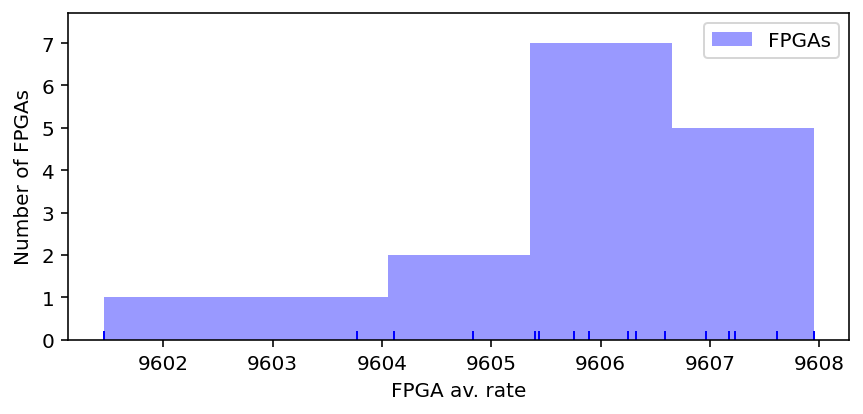

In [81]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list_swap,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')
plt.savefig("312 YAKLAŞTIRMA even after event buffer swap total rate+AFTER BETTER SWAP.png")


/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/taylan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Number of lpGBTs'), Text(0, 0.5, 'Number of FPGAs')]

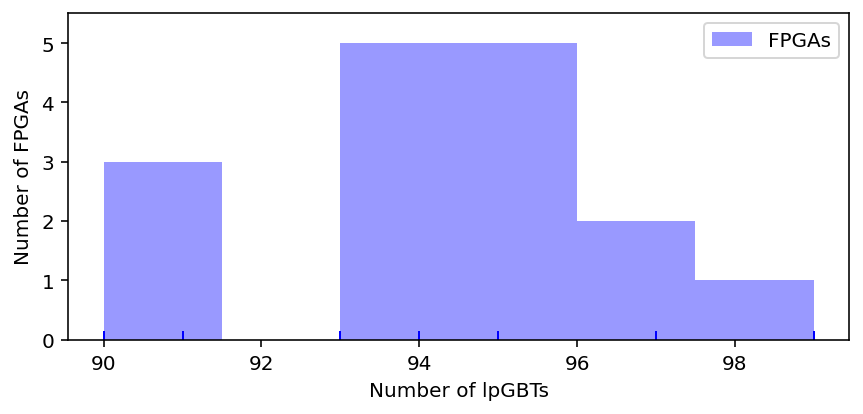

In [83]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_lpGBT_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Number of lpGBTs', ylabel='Number of FPGAs')
#plt.savefig("312 YAKLAŞTIRMA event buffer swap LPGBT NUMBER +AFTER BETTER SWAP.png")